![Machine Learning Lab](banner.jpg)


# Laboratorio 4 Actividad


## Instrucciones generales


1. Esta actividad debe ser entregada por BN y es de carácter individual. No se permite entregar el laboratorio después de la fecha establecida.
2. Al responder las preguntas de las actividades por favor marcar las respuestas con la sección a la que corresponden, por ejemplo: `## Exploración de datos 2.1`. Es preferible que esto lo hagan con secciones de MarkDown.
3. Por favor nombrar el archivo de acuerdo al siguiente formato `{email}_lab4.ipynb`.
4. Si tienen alguna duda pueden escribirme a mi correo `j.rayom@uniandes.edu.co` o contactarme directamente por Teams

Para este laboratorio deben usar el siguiente dataset de Telco Customer Churn: `https://www.kaggle.com/datasets/mosapabdelghany/telcom-customer-churn-dataset`

* * *

Instrucciones
-------------

### 0\. Descarga del Dataset

Utiliza el siguiente enlace para descargar el dataset de Telco Customer Churn desde Kaggle:

[Descargar Dataset](https://www.kaggle.com/datasets/mosapabdelghany/telcom-customer-churn-dataset)

El dataset contiene información de clientes de una empresa de telecomunicaciones y su comportamiento de abandono (churn). En este laboratorio nuestra variable objetivo será la columna `Churn`.

### 1\. Exploración de datos (5%)

1. Carga el dataset en un DataFrame de pandas.
2. Analiza la distribución de la variable objetivo `Churn` y crea una visualización con un gráfico de barras.

### 2\. Preprocesamiento de Datos (15%)

1. **Limpieza de datos**: Convierte la columna `TotalCharges` a numérico y maneja los valores nulos reemplazándolos por `MonthlyCharges * tenure`.
2. **Eliminar columna irrelevante**: Remueve la columna `customerID`.
3. **Separación de variables**: Separa las características (X) de la variable objetivo (y = `Churn`).
4. **División train/test**: Divide los datos en conjuntos de entrenamiento y prueba usando `train_test_split` con `test_size=0.2`, `random_state=42` y `stratify=y`.
5. **Pipeline de preprocesamiento**: Crea pipelines separados para variables numéricas (con `SimpleImputer` y `StandardScaler`) y categóricas (con `SimpleImputer` y `OneHotEncoder`), luego combínalos con `ColumnTransformer`.

### 3\. Entrenamiento de modelo (60%)

Para cada uno de los siguientes modelos `DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier` realizar los siguientes pasos:

1. **Entrenar el modelo**: Ajusta cada modelo usando los datos de entrenamiento preprocesados. Usa `LabelEncoder` para convertir las etiquetas categóricas a numérica.
2. **Matriz de confusión**: Grafica la matriz de confusión del modelo.
3. **Reporte de clasificación**: Genera y muestra el reporte de clasificación.
4. **Análisis SHAP**: Grafica los valores SHAP para interpretar la importancia de las variables (Excluyendo AdaBoostClassifier).
5. **Árbol de decisión**: Para `DecisionTreeClassifier`, grafica los primeros 3 niveles del árbol.
6. **Importancia de variables**: ¿Cuales son las dos variables más importantes para esta tarea de clasificación según los resultados obtenidos? Justifique su respuesta.


### 4\. Gráfica de frontera de decisiones (20%)

1. **Visualización de fronteras**: Usa la función `plot_class_boundaries` presentada abajo para graficar las fronteras de decisión de un `DecisionTreeClassifier` y un `RandomForestClassifier`. Utiliza las dos variables numéricas más importantes identificadas en el punto anterior con valores de `max_depth` de `3, 10, 100`.

¿Qué diferencias observa entre usar `max_depth=3`, `max_depth=10` y `max_depth=100`? ¿Cómo cree que esto afecte el overfitting? Analice las fronteras de decisión y la estructura del árbol.


In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
import kagglehub
from warnings import filterwarnings

# ignorar warnings 
filterwarnings("ignore")
%matplotlib inline 

# procesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler, 
    OneHotEncoder
)

# modelos
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# metricas
from sklearn.metrics import classification_report, confusion_matrix

# graficos
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [125]:
def generate_palette(n, cmap_name='viridis'):
    cmap = cm.get_cmap(cmap_name, n)
    return [mcolors.to_hex(cmap(i)) for i in range(n)]

def plot_class_boundaries(X_train_processed, y_train, column_1, column_2, model_class, **model_kwargs):
    """
    Grafica las fronteras de decisión de un modelo de clasificación basado en dos características
    seleccionadas de los datos de entrenamiento. Esta función ajusta el modelo dado en las
    columnas de características proporcionadas y visualiza las regiones de decisión, fronteras
    de clase y puntos de entrenamiento en un gráfico 2D.

    :param X_train_processed: DataFrame que contiene los datos de entrenamiento procesados.
    :param y_train: Las etiquetas objetivo correspondientes a los datos de entrenamiento.
    :param column_1: El nombre de la primera columna de características para graficar fronteras.
    :param column_2: El nombre de la segunda columna de características para graficar fronteras.
    :param model_class: La clase de clasificador a instanciar para ajuste y visualización.
    :param model_kwargs: Argumentos adicionales para inicializar la instancia del clasificador.
    :return: None
    """
    # Extraer solo las dos columnas especificadas
    X_train_selected = X_train_processed[[column_1, column_2]].values

    # Codificar y_train a binario para la visualización
    y_train_binary = (y_train == 'Yes').astype(int)

    # Entrenar el modelo
    model = model_class(**model_kwargs)
    model.fit(X_train_selected, y_train_binary)

    # Generar una malla de puntos
    x_min, x_max = X_train_selected[:, 0].min() - 1, X_train_selected[:, 0].max() + 1
    y_min, y_max = X_train_selected[:, 1].min() - 1, X_train_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predecir en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Generar paleta de colores
    # Configurar colores
    colors = ['lightblue', 'lightcoral']
    cmap = ListedColormap(colors)

    # Graficar fronteras de decisión
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # Graficar puntos de entrenamiento
    scatter = plt.scatter(X_train_selected[:, 0], X_train_selected[:, 1], c=y_train_binary, cmap=cmap, edgecolor='k')

    # Etiquetas y título
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(f'Fronteras de Decisión usando {model_class.__name__}')

    # Agregar leyenda
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Clases")
    plt.show()

    if model_class == DecisionTreeClassifier:
        # graficar la estructura del árbol
        plt.figure(figsize=(15, 10))
        plot_tree(model, filled=True, feature_names=[column_1, column_2], 
                 class_names=['No Churn', 'Churn'])
        plt.title(f'Estructura del Árbol - {model_kwargs}', fontsize=14)
        plt.tight_layout()
        plt.show()

### 0. Descarga del dataset

In [ ]:
# descargar desde kagglehub
path = kagglehub.dataset_download("mosapabdelghany/telcom-customer-churn-dataset")

print("Path to dataset files:", path)

100%|██████████| 172k/172k [00:00<00:00, 1.26MB/s]

Extracting files...
Path to dataset files: /Users/estefanialaverdebecerra/.cache/kagglehub/datasets/mosapabdelghany/telcom-customer-churn-dataset/versions/1


**NOTA:** tras descargar el dataset, se guarda en la ruta *datasets/*

### 1\. Exploración de datos (5%)

1. Carga el dataset en un DataFrame de pandas.
2. Analiza la distribución de la variable objetivo `Churn` y crea una visualización con un gráfico de barras.

In [3]:
df_churn = pd.read_csv("datasets/Telco_Cusomer_Churn.csv")
df_churn.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

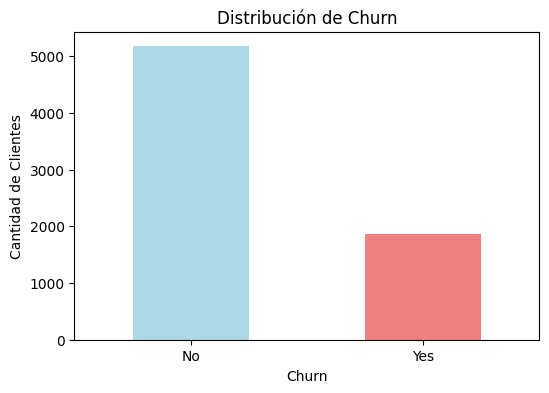

In [4]:
# analizamos la variable objetivo churn con un grafico de barras
churn_counts = df_churn['Churn'].value_counts()

plt.figure(figsize=(6, 4))
churn_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=0)
plt.show()

Con el gráfico de barras se puede observar que aproximadamente 5000 clientes no abandonaron el servicio, mientras que alrededor de 2000 si lo hicieron. Esto indica que los datos son desbalanceados, lo que podría afectar el rendimiento de los modelos de clasificación.

### 2\. Preprocesamiento de Datos (15%)

1. **Limpieza de datos**: Convierte la columna `TotalCharges` a numérico y maneja los valores nulos reemplazándolos por `MonthlyCharges * tenure`.
2. **Eliminar columna irrelevante**: Remueve la columna `customerID`.
3. **Separación de variables**: Separa las características (X) de la variable objetivo (y = `Churn`).
4. **División train/test**: Divide los datos en conjuntos de entrenamiento y prueba usando `train_test_split` con `test_size=0.2`, `random_state=42` y `stratify=y`.
5. **Pipeline de preprocesamiento**: Crea pipelines separados para variables numéricas (con `SimpleImputer` y `StandardScaler`) y categóricas (con `SimpleImputer` y `OneHotEncoder`), luego combínalos con `ColumnTransformer`.

In [ ]:
#1. limpieza de TotalCharges
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors = "coerce") # convertir a numérico, si hay errores se ponen en nan
df_churn['TotalCharges'].fillna(df_churn['MonthlyCharges'] * df_churn['tenure'], inplace=True) # rellenar los nan con monthlycharges * tenure

#2. eliminar customerID
df_churn.drop(columns=['customerID'], inplace=True)

#3. separar X y Y
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

#4. dividir train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #NOTA: stratify=y se usa para mantener la misma proporción de clases en train y test, ya que el dataset está desbalanceado.

#5. pipelines para variables numéricas y categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['number']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# preprocesar
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

num_col_names = numerical_features.tolist()
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_col_names = encoder.get_feature_names_out(categorical_features).tolist()
final_column_names = num_col_names + cat_col_names

X_train_processed = pd.DataFrame(X_train_processed, columns=final_column_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=final_column_names)


### 3\. Entrenamiento de modelo (60%)

Para cada uno de los siguientes modelos `DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier` realizar los siguientes pasos:

1. **Entrenar el modelo**: Ajusta cada modelo usando los datos de entrenamiento preprocesados. Usa `LabelEncoder` para convertir las etiquetas categóricas a numérica.
2. **Matriz de confusión**: Grafica la matriz de confusión del modelo.
3. **Reporte de clasificación**: Genera y muestra el reporte de clasificación.
4. **Análisis SHAP**: Grafica los valores SHAP para interpretar la importancia de las variables (Excluyendo AdaBoostClassifier).
5. **Árbol de decisión**: Para `DecisionTreeClassifier`, grafica los primeros 3 niveles del árbol.
6. **Importancia de variables**: ¿Cuales son las dos variables más importantes para esta tarea de clasificación según los resultados obtenidos? Justifique su respuesta.

Primero se define la función full_model_report, la cual recibe un modelo, los datos de entrenamiento y prueba, y el nombre del modelo. Esta función se encarga de entrenar el modelo, generar la matriz de confusión, el reporte de clasificación y los valores SHAP (si aplica).

Los valores SHAP se utilizan para interpretar la importancia de las variables en el modelo. En la función original, se para graficar los valores SHAP se utilizaba `shap.summary_plot(shap_values, X_test)`, sin embargo, al leer la documentación de SHAP, se recomienda cambiarlo a `shap.plots.beeswarm(...)` para evitar problemas de visualización.

In [113]:
def full_model_report(model, X_train, X_test, y_train, y_test, skip_shap=False):
    """
    Entrena el modelo y genera un reporte completo del rendimiento de un modelo de clasificación.

    Args:
        model: Modelo de clasificación a evaluar.
        X_train: Datos de entrenamiento.
        X_test: Datos de prueba.
        y_train: Etiquetas de entrenamiento.
        y_test: Etiquetas de prueba.
        skip_shap (bool): Si True, omite análisis SHAP. Default False.

    Muestra métricas de clasificación, matriz de confusión y análisis SHAP.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

    if skip_shap:
        return

    explainer = shap.Explainer(model, X_train)

    shap_vals = explainer(X_test, check_additivity=False)

    print(f"\nFeature Importance according to SHAP - {model.__class__.__name__}")
    print(shap_vals)

    # cambio shap.summary_plot pro shap.plots.beeswarm por ser una función más reciente
    # la función shap.plots.beeswarm espera una matriz de shap values con shape (n_samples, n_features, n_classes)
    # seleccionamos la clase YES (el cliente hace churn) que corresponde al índice 1 (viendo el label encoder)
    if len(shap_vals.shape) == 3:
        shap_exp = shap_vals[:, :, 1] 
    else:
        shap_exp = shap_vals

    plt.figure(figsize=(12, 8))
    shap.plots.beeswarm(shap_exp, max_display=15, show=False)
    
    plt.tight_layout()
    plt.show()



In [114]:
#Transformar las etiquetas con LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Etiquetas codificadas:", label_encoder.classes_)

Etiquetas codificadas: ['No' 'Yes']


### Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1035
           1       0.47      0.48      0.48       374

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



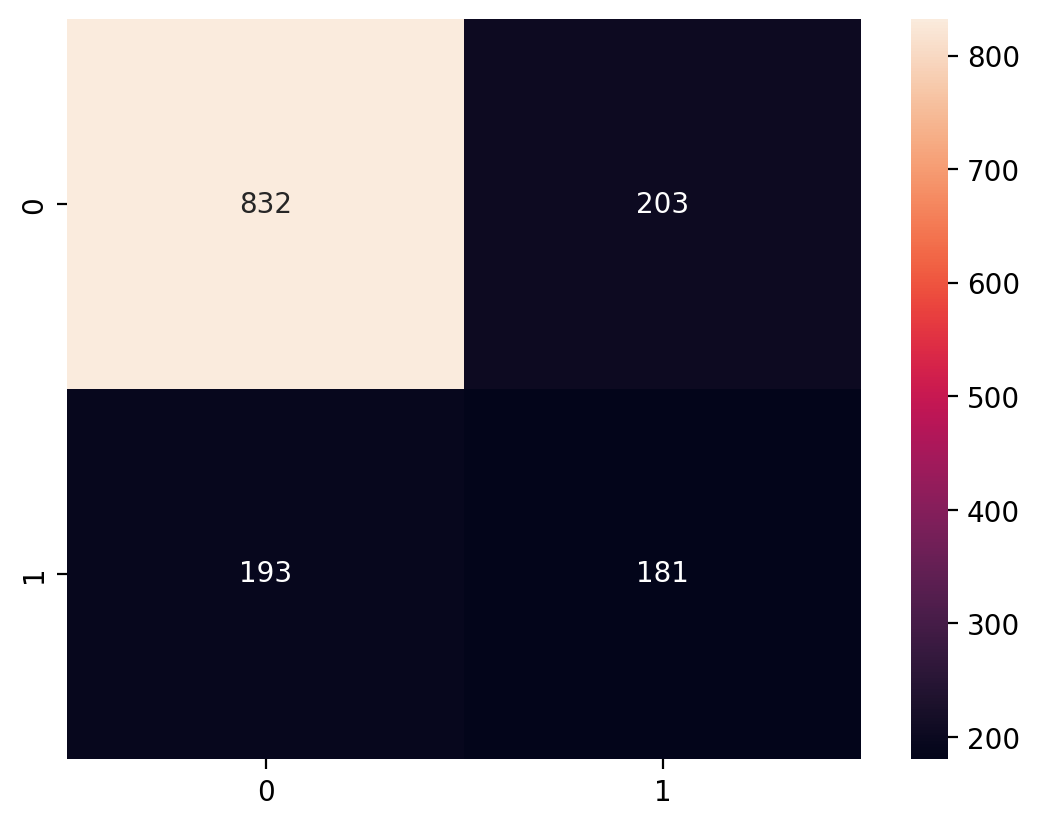


Feature Importance according to SHAP - DecisionTreeClassifier
.values =
array([[[ 1.02817465e-02, -1.02817464e-02],
        [ 5.25126276e-02, -5.25126288e-02],
        [-7.06357183e-04,  7.06348949e-04],
        ...,
        [-1.53318892e-03,  1.53318907e-03],
        [ 2.60353540e-02, -2.60353542e-02],
        [ 2.38961033e-03, -2.38961043e-03]],

       [[-1.04365108e-03,  1.04365012e-03],
        [-4.68730193e-02,  4.68730141e-02],
        [-2.09234132e-01,  2.09234132e-01],
        ...,
        [-4.19047630e-03,  4.19047644e-03],
        [ 4.09126946e-03, -4.09126987e-03],
        [-5.79365210e-04,  5.79365033e-04]],

       [[ 1.75916310e-02, -1.75916311e-02],
        [ 1.64830453e-02, -1.64830445e-02],
        [ 3.11742463e-02, -3.11742431e-02],
        ...,
        [-4.88852819e-03,  4.88852826e-03],
        [ 1.78124112e-02, -1.78124098e-02],
        [-2.00036110e-03,  2.00036080e-03]],

       ...,

       [[ 4.32142872e-03, -4.32142867e-03],
        [ 6.05591697e-03, -6.0559

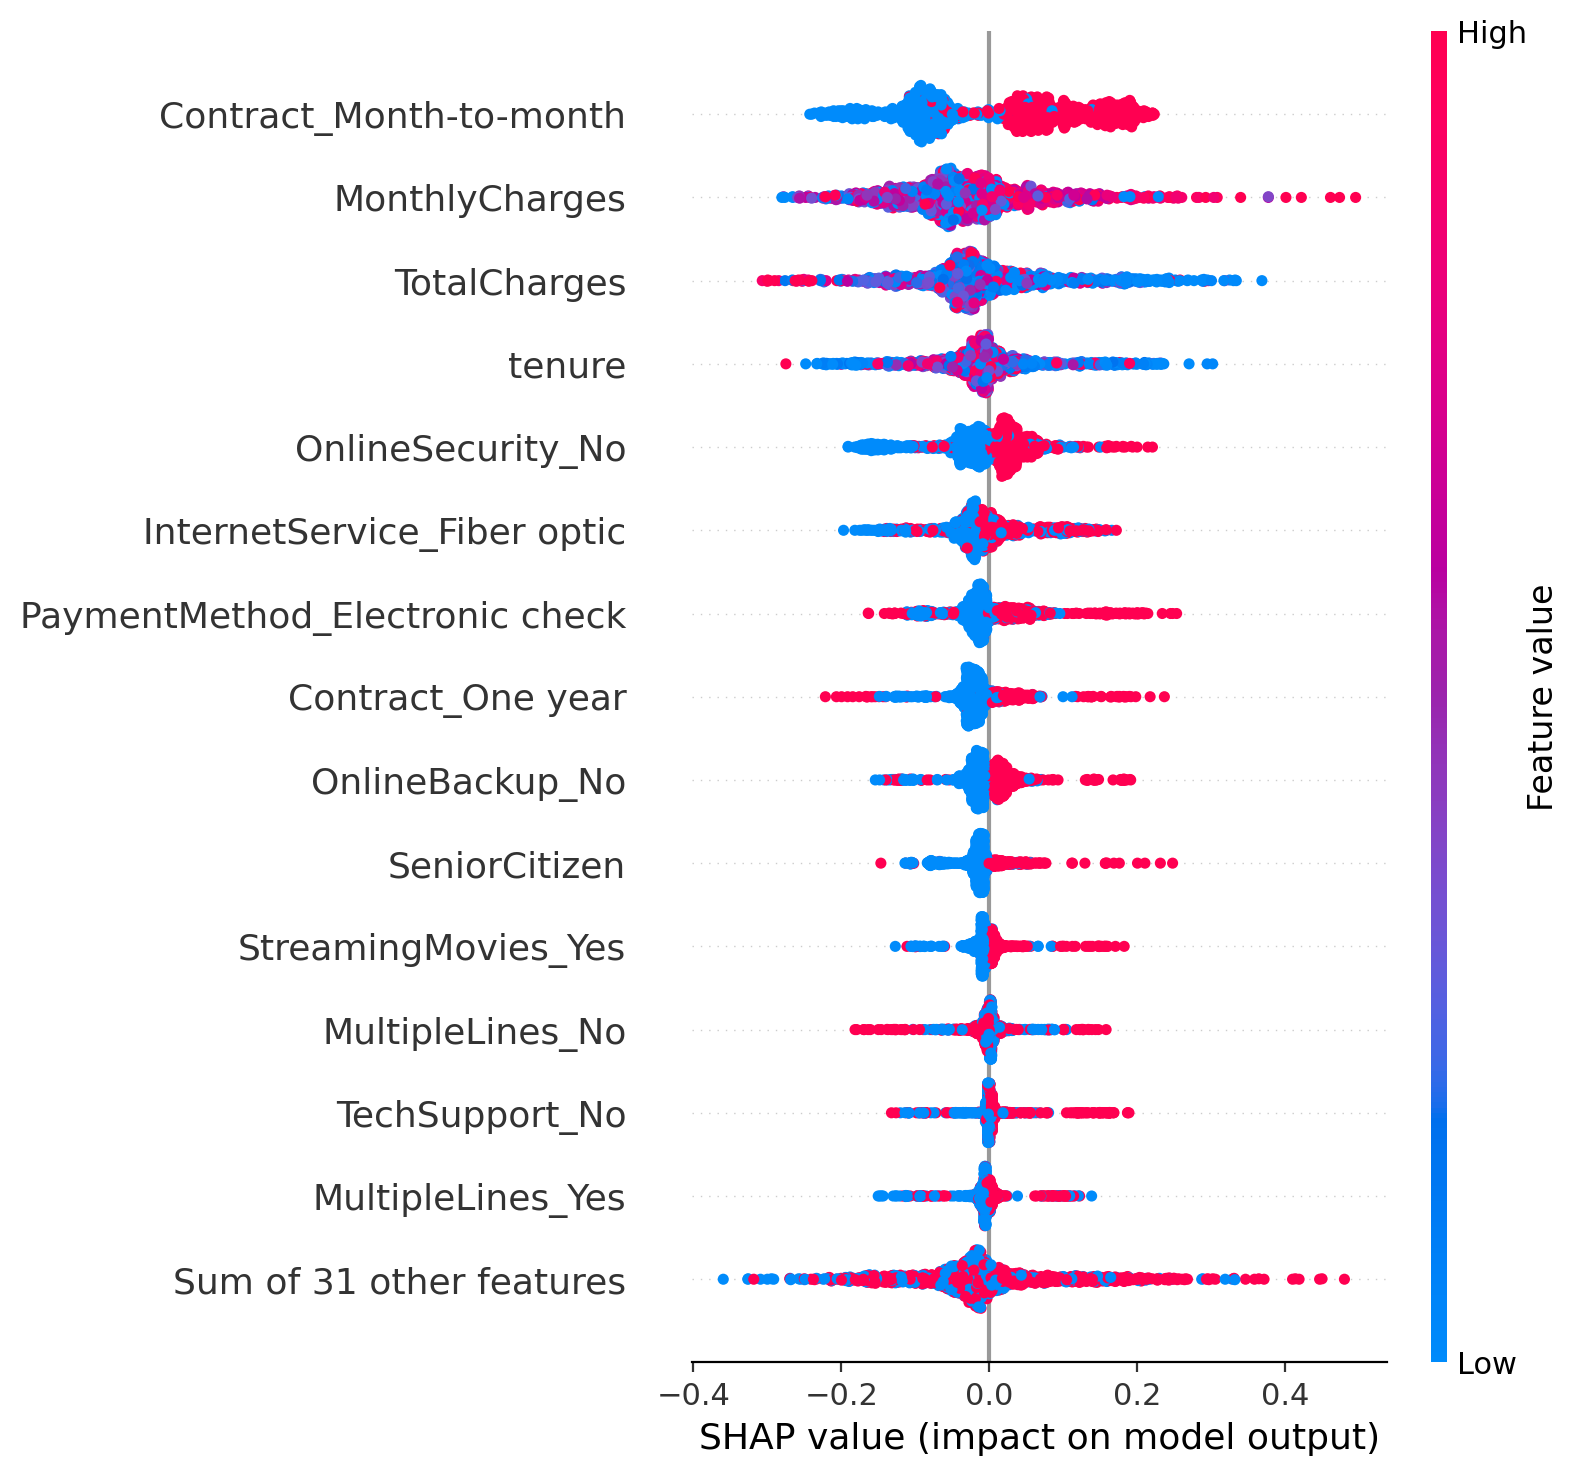

In [115]:
# entrenar y evaluar Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
full_model_report(dt_model, X_train_processed, X_test_processed, y_train_encoded, y_test_encoded)

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



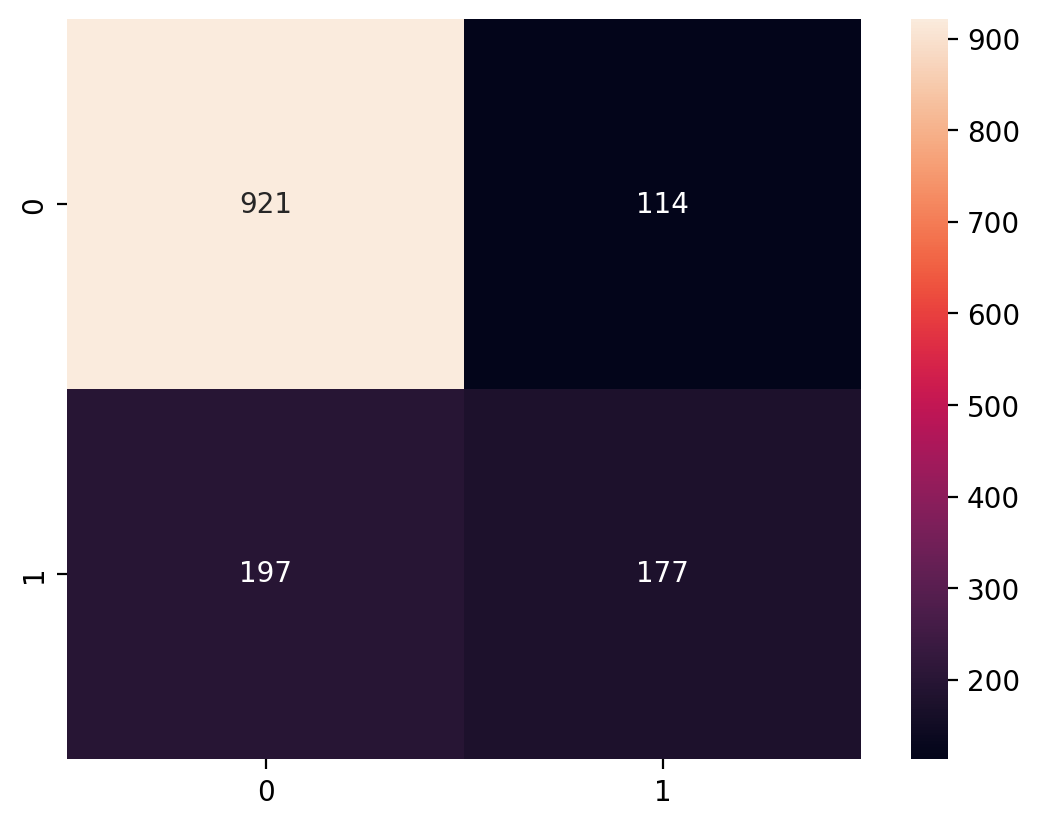

 99%|===================| 2800/2818 [01:13<00:00]        


Feature Importance according to SHAP - RandomForestClassifier
.values =
array([[[ 0.00602136, -0.00602136],
        [ 0.06887191, -0.06887191],
        [-0.00334204,  0.00334204],
        ...,
        [ 0.00561063, -0.00561063],
        [ 0.01039934, -0.01039934],
        [ 0.00018786, -0.00018786]],

       [[-0.0154619 ,  0.0154619 ],
        [-0.08042344,  0.08042344],
        [-0.04556539,  0.04556539],
        ...,
        [ 0.02219703, -0.02219703],
        [ 0.01979138, -0.01979138],
        [-0.00081459,  0.00081459]],

       [[ 0.0088958 , -0.0088958 ],
        [ 0.02358908, -0.02358908],
        [ 0.00802741, -0.00802741],
        ...,
        [ 0.00783563, -0.00783563],
        [ 0.01334934, -0.01334934],
        [ 0.0007241 , -0.0007241 ]],

       ...,

       [[ 0.00740778, -0.00740778],
        [-0.02876041,  0.02876041],
        [ 0.04179571, -0.04179571],
        ...,
        [-0.00053499,  0.00053499],
        [ 0.00910564, -0.00910564],
        [-0.00135089,  0.001

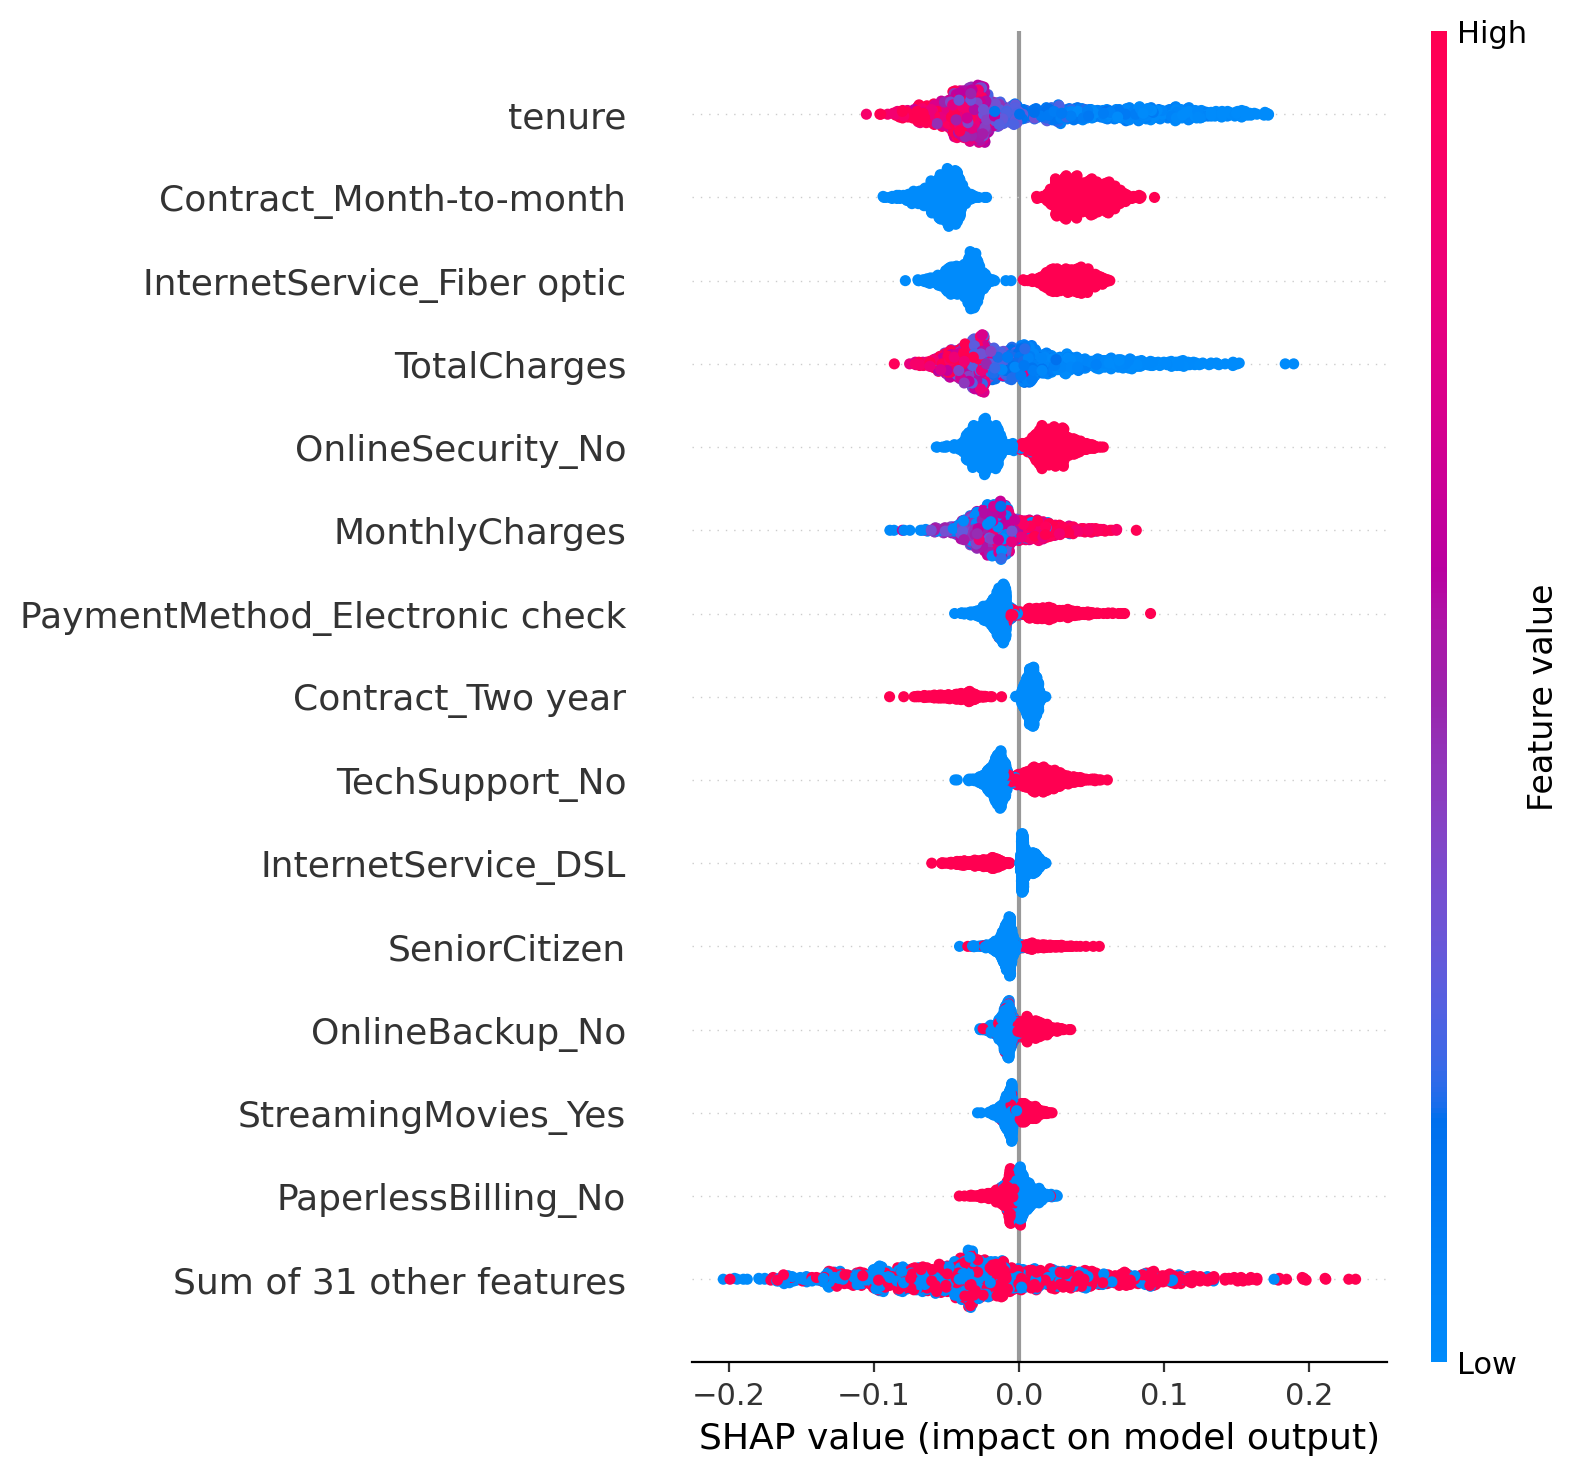

In [ ]:
# entrenar y evaluar Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
full_model_report(rf_model, X_train_processed, X_test_processed, y_train_encoded, y_test_encoded)

### AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



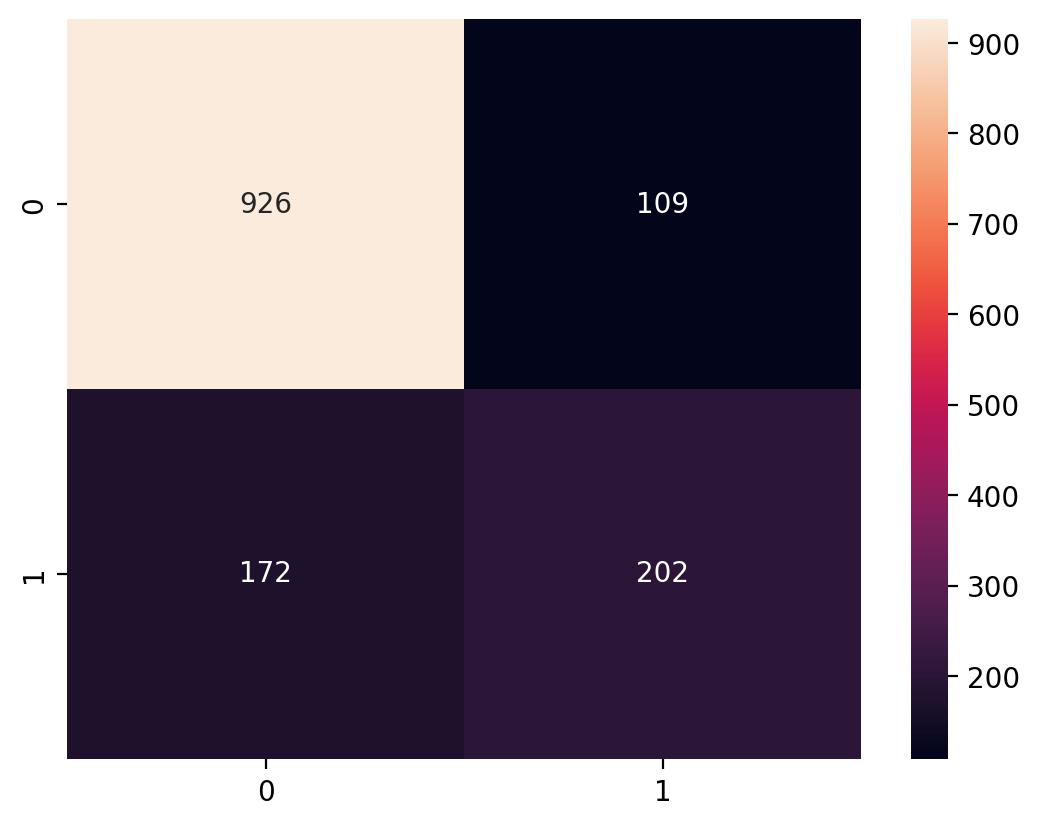

In [ ]:
# entrenar y evaluar AdaBoost Classifier
ab_model = AdaBoostClassifier(random_state=42, n_estimators=100)
full_model_report(ab_model, X_train_processed, X_test_processed, y_train_encoded, y_test_encoded, skip_shap=True) # SHAP no admite AdaBoostClassifier

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



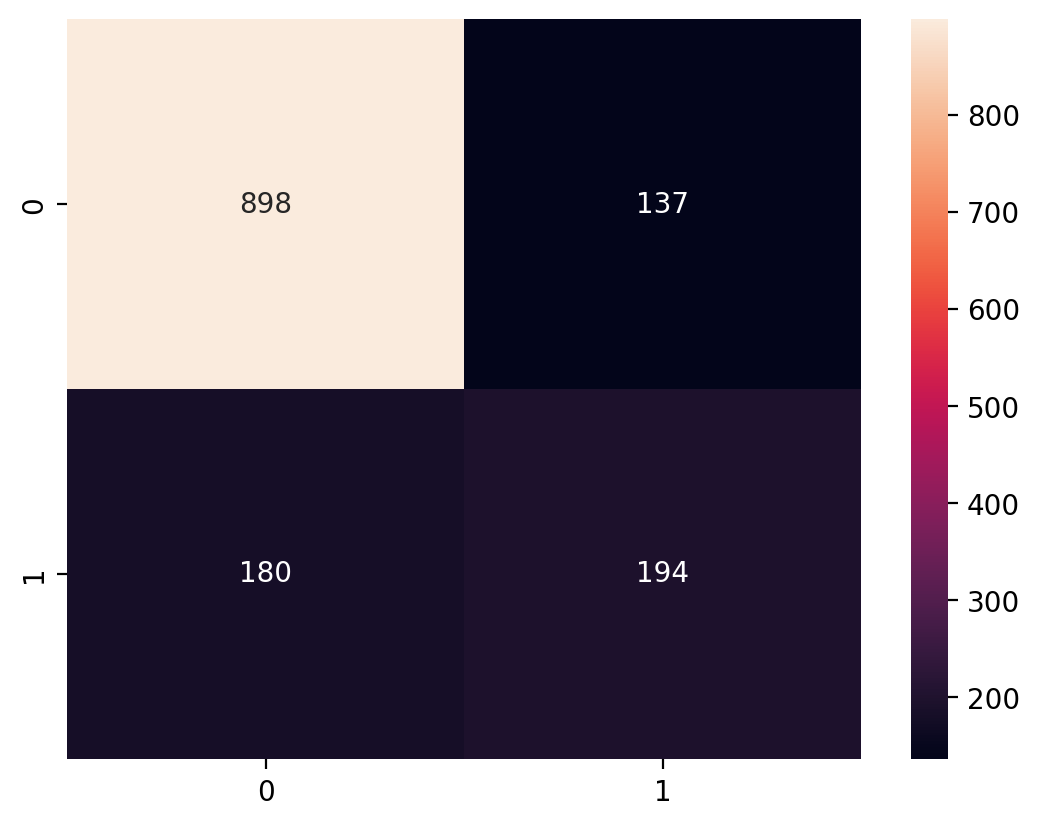


Feature Importance according to SHAP - XGBClassifier
.values =
array([[-9.69661738e-02, -2.25741619e+00, -2.74305937e-01, ...,
        -5.99090984e-02, -1.82749715e-01,  8.04892911e-02],
       [ 2.10156005e-01,  1.14350610e+00,  8.70454374e-01, ...,
        -1.15253269e-01, -3.73000036e-02, -1.59624111e-02],
       [-1.52151236e-01,  2.06453304e-02,  1.39802042e-01, ...,
         1.06796499e-01, -1.84352852e-01,  4.93014566e-02],
       ...,
       [-1.48551772e-01,  1.12242740e+00, -1.09200040e+00, ...,
         1.49432769e-03, -5.16321192e-02,  3.05254138e-02],
       [-2.01045267e-01,  6.21985999e-01,  5.83339452e-01, ...,
         1.10099910e-01, -5.99539238e-02,  5.07859022e-02],
       [-1.76152513e-01, -3.18046184e+00, -8.79697621e-02, ...,
        -5.23000233e-02, -3.17748804e-01,  1.15608060e-01]])

.base_values =
array([-2.10945331, -2.10945331, -2.10945331, ..., -2.10945331,
       -2.10945331, -2.10945331])

.data =
array([[-0.44177295,  1.60848343,  1.62997635, ...,  1. 

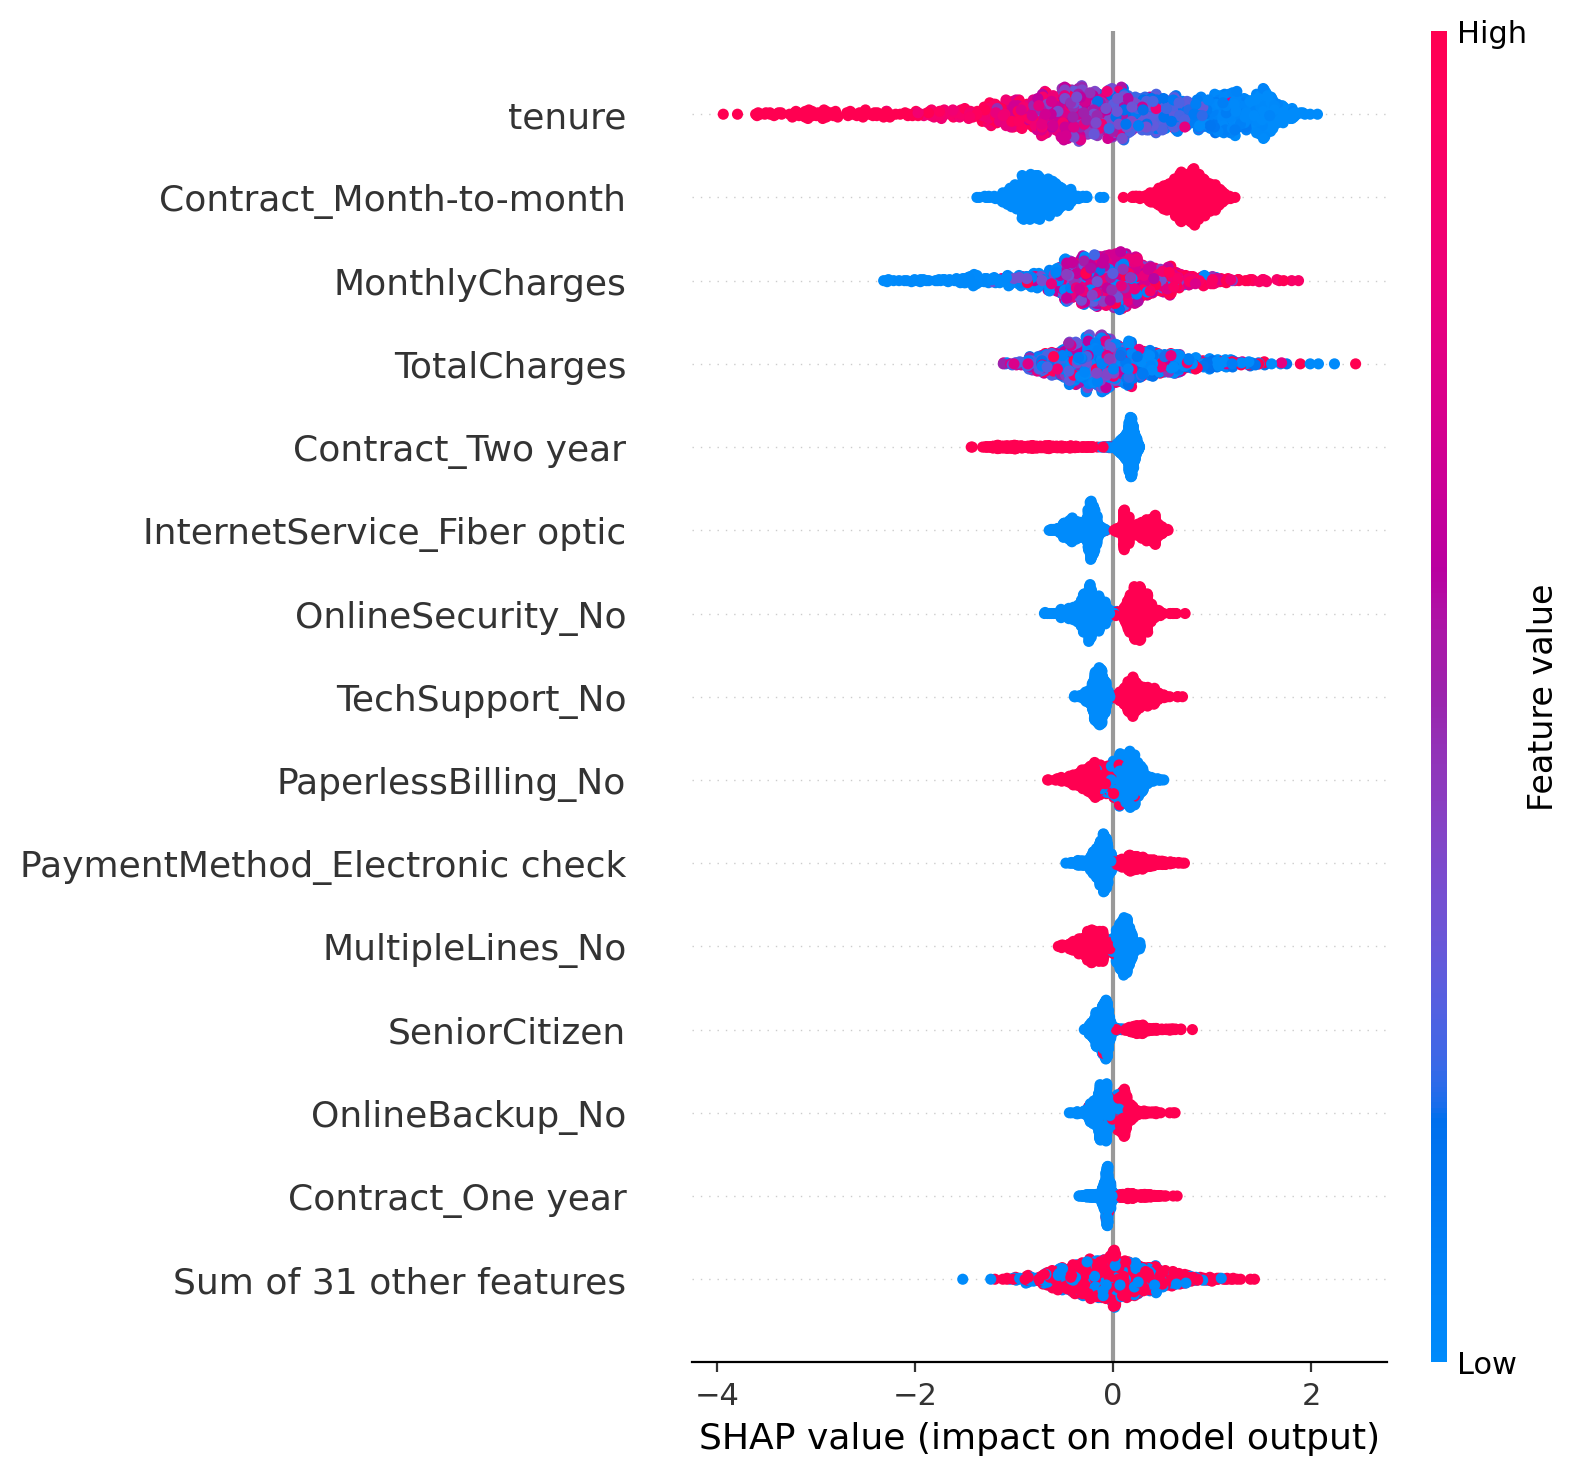

In [ ]:
# entrenar y evaluar XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
full_model_report(xgb_model, X_train_processed, X_test_processed, y_train_encoded, y_test_encoded)

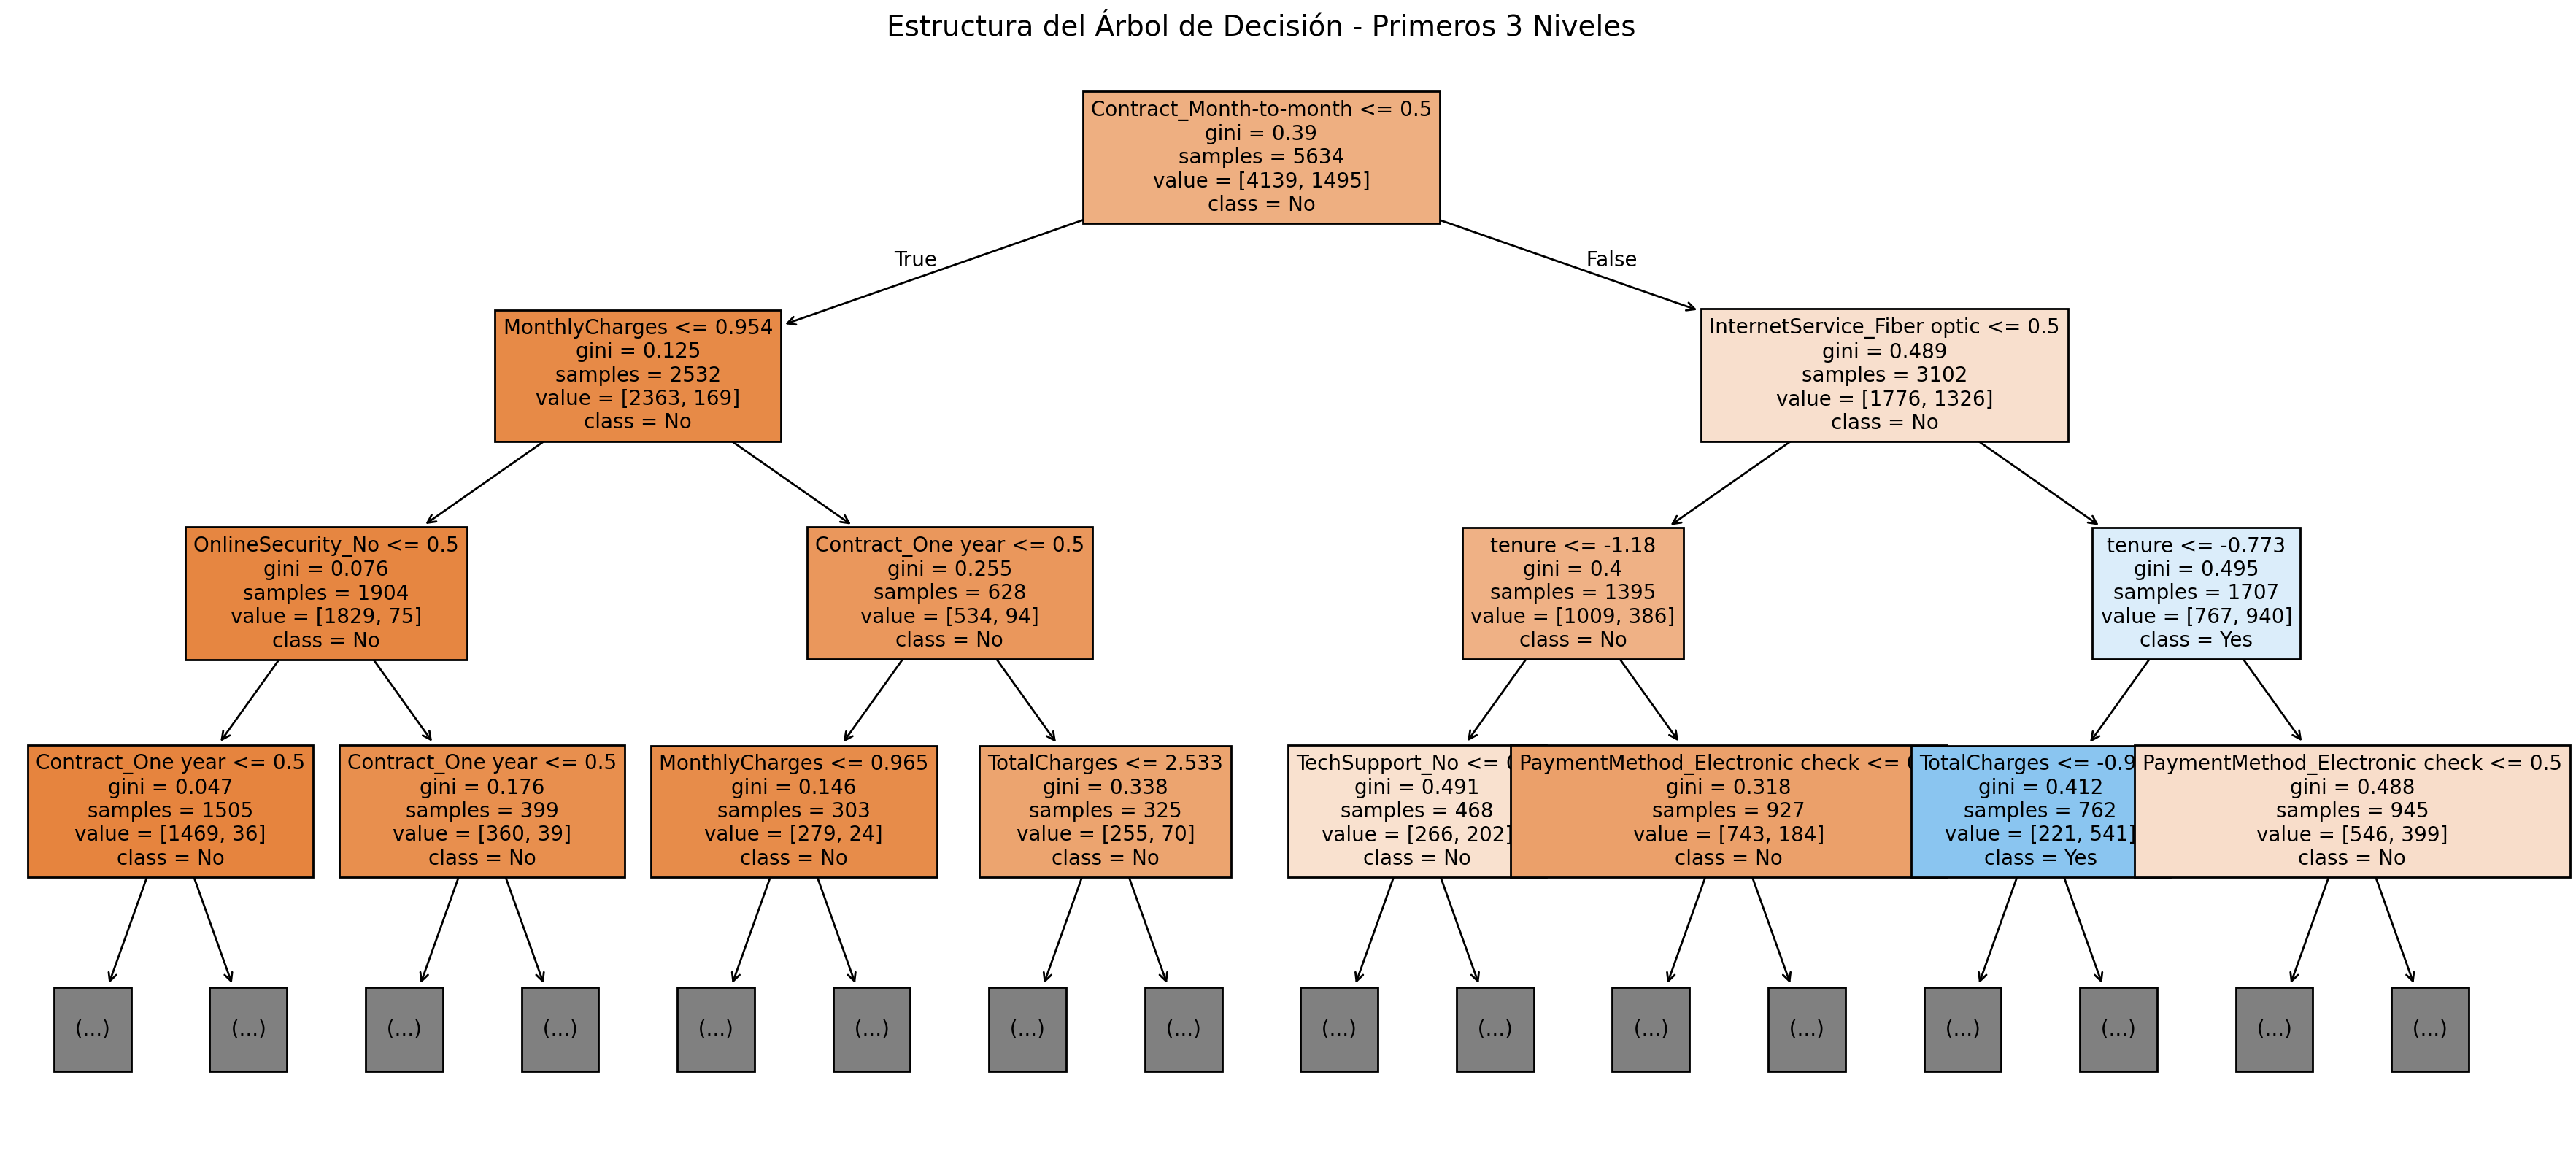

In [116]:
#5. graficar los tres primeros niveles del arbol de decision
plt.figure(figsize=(18, 8))
plot_tree(dt_model, filled=True, feature_names=final_column_names, class_names=label_encoder.classes_, max_depth=3, fontsize=10)
plt.title('Estructura del Árbol de Decisión - Primeros 3 Niveles', fontsize=14)
plt.tight_layout()
plt.show()

La importancia de las variables se puede determinar o bien a través de los valores de SHAP o según los niveles del árbol de decisión. En este último caso, las variables que se encuentran en los primeros niveles del árbol son las más importantes, pues son las que garantizan mayor pureza en las particiones. De esta manera, concluimos que las variables más importantes para esta tarea son Contract_month-to-month y InternetService_Fiber optic. Contract_month-to-month al ser el primer nivel del árbol de decisión, e InternetService_Fiber optic pues es la variable con un valor de gini más alto en comparación con MonthlyCharges, indicando que es la variable que más contribuye a la pureza de las particiones.

### 4\. Gráfica de frontera de decisiones (20%)

1. **Visualización de fronteras**: Usa la función `plot_class_boundaries` presentada abajo para graficar las fronteras de decisión de un `DecisionTreeClassifier` y un `RandomForestClassifier`. Utiliza las dos variables numéricas más importantes identificadas en el punto anterior con valores de `max_depth` de `3, 10, 100`.

¿Qué diferencias observa entre usar `max_depth=3`, `max_depth=10` y `max_depth=100`? ¿Cómo cree que esto afecte el overfitting? Analice las fronteras de decisión y la estructura del árbol.

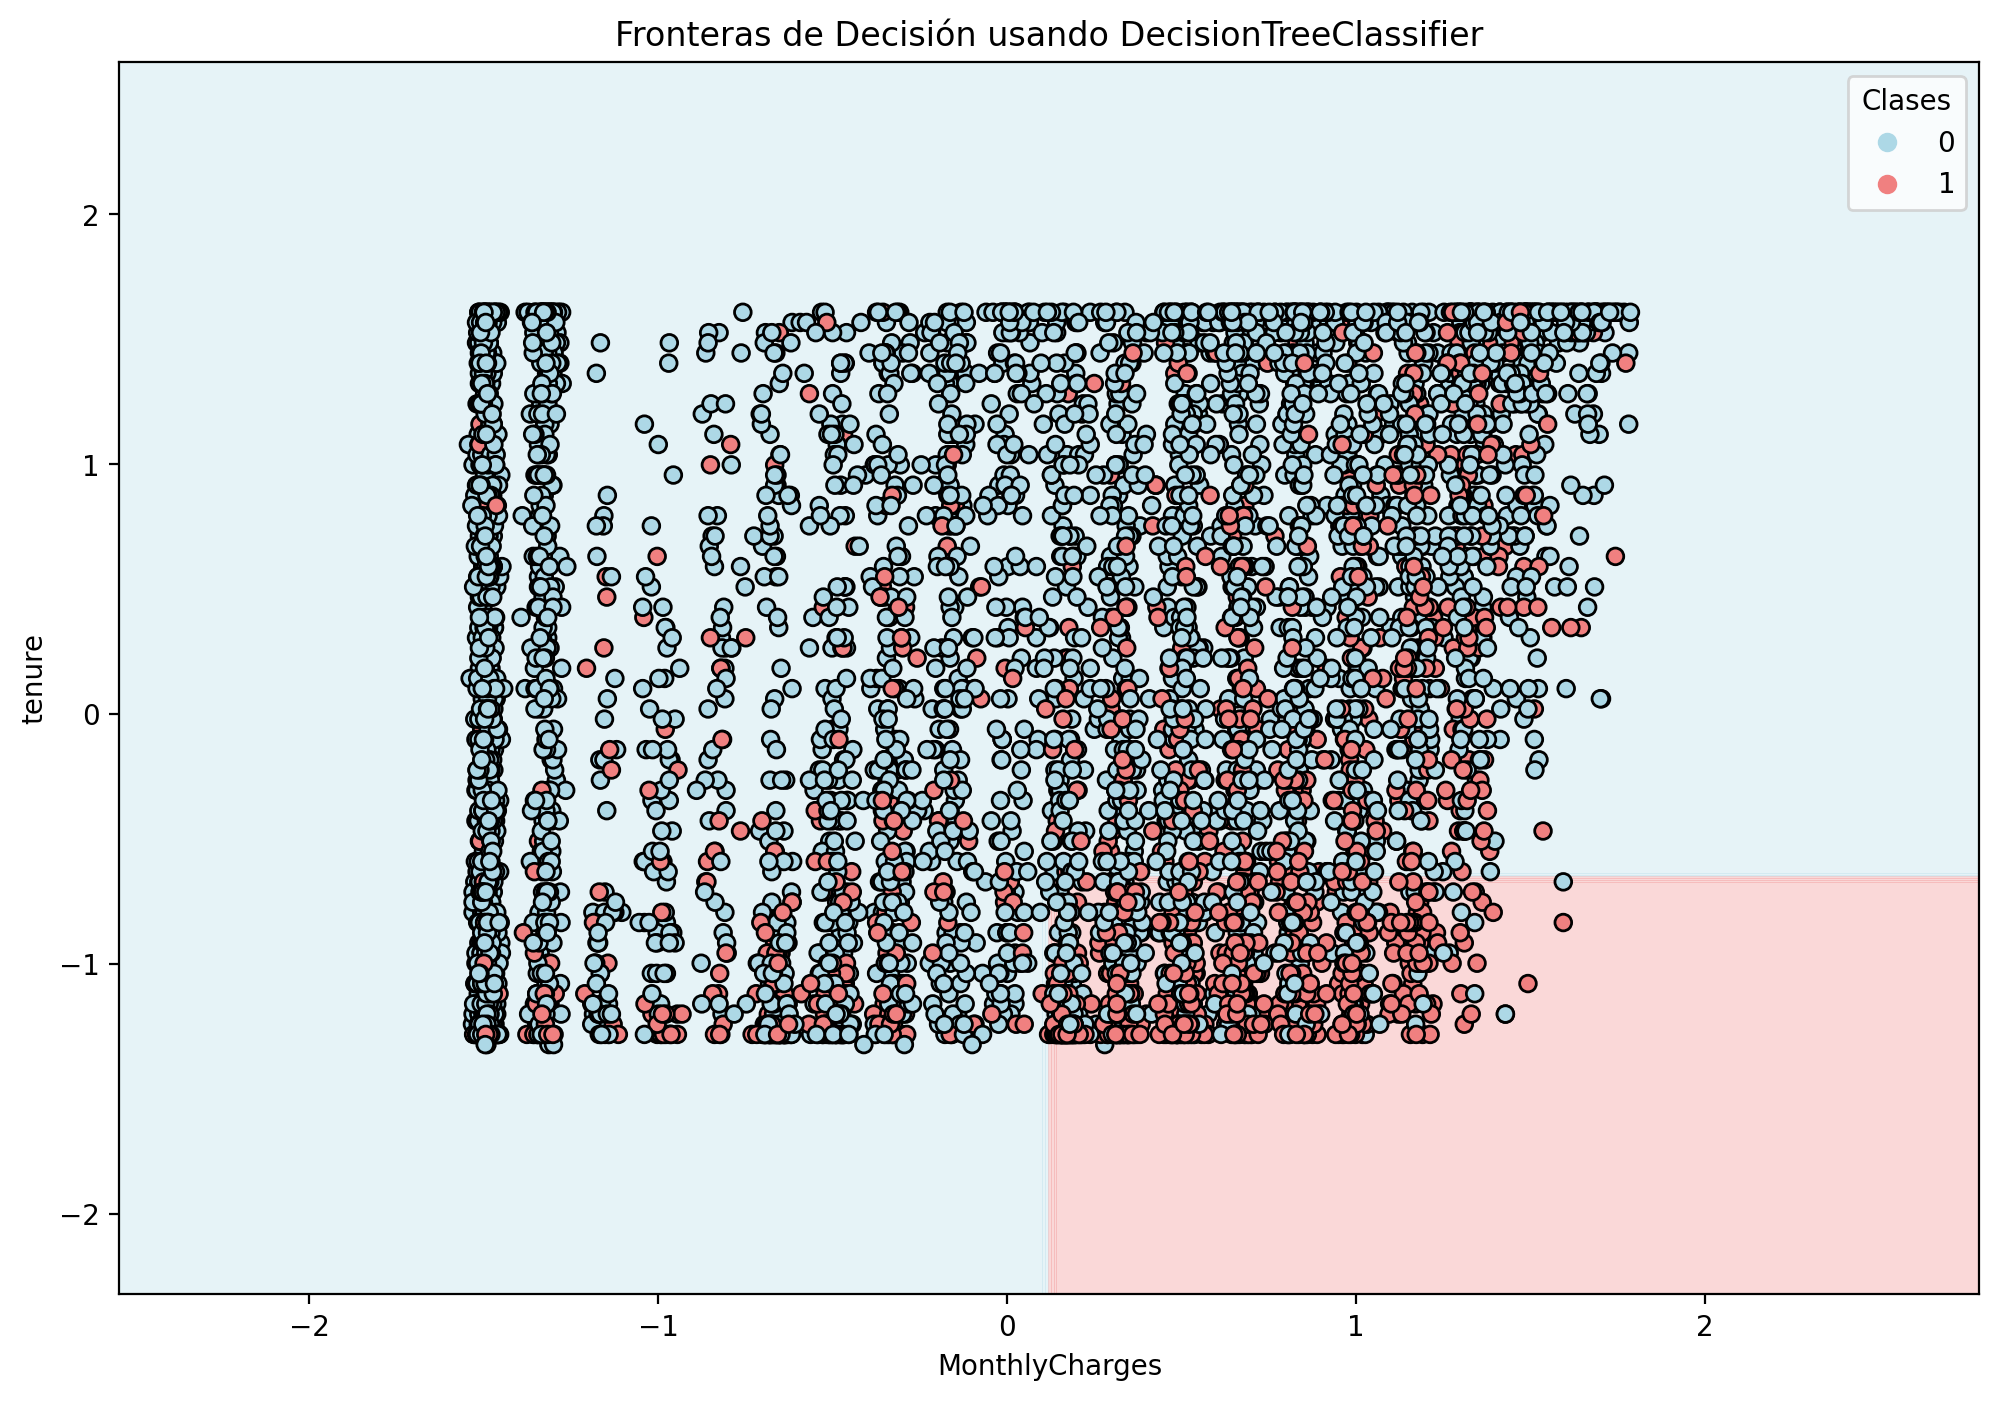

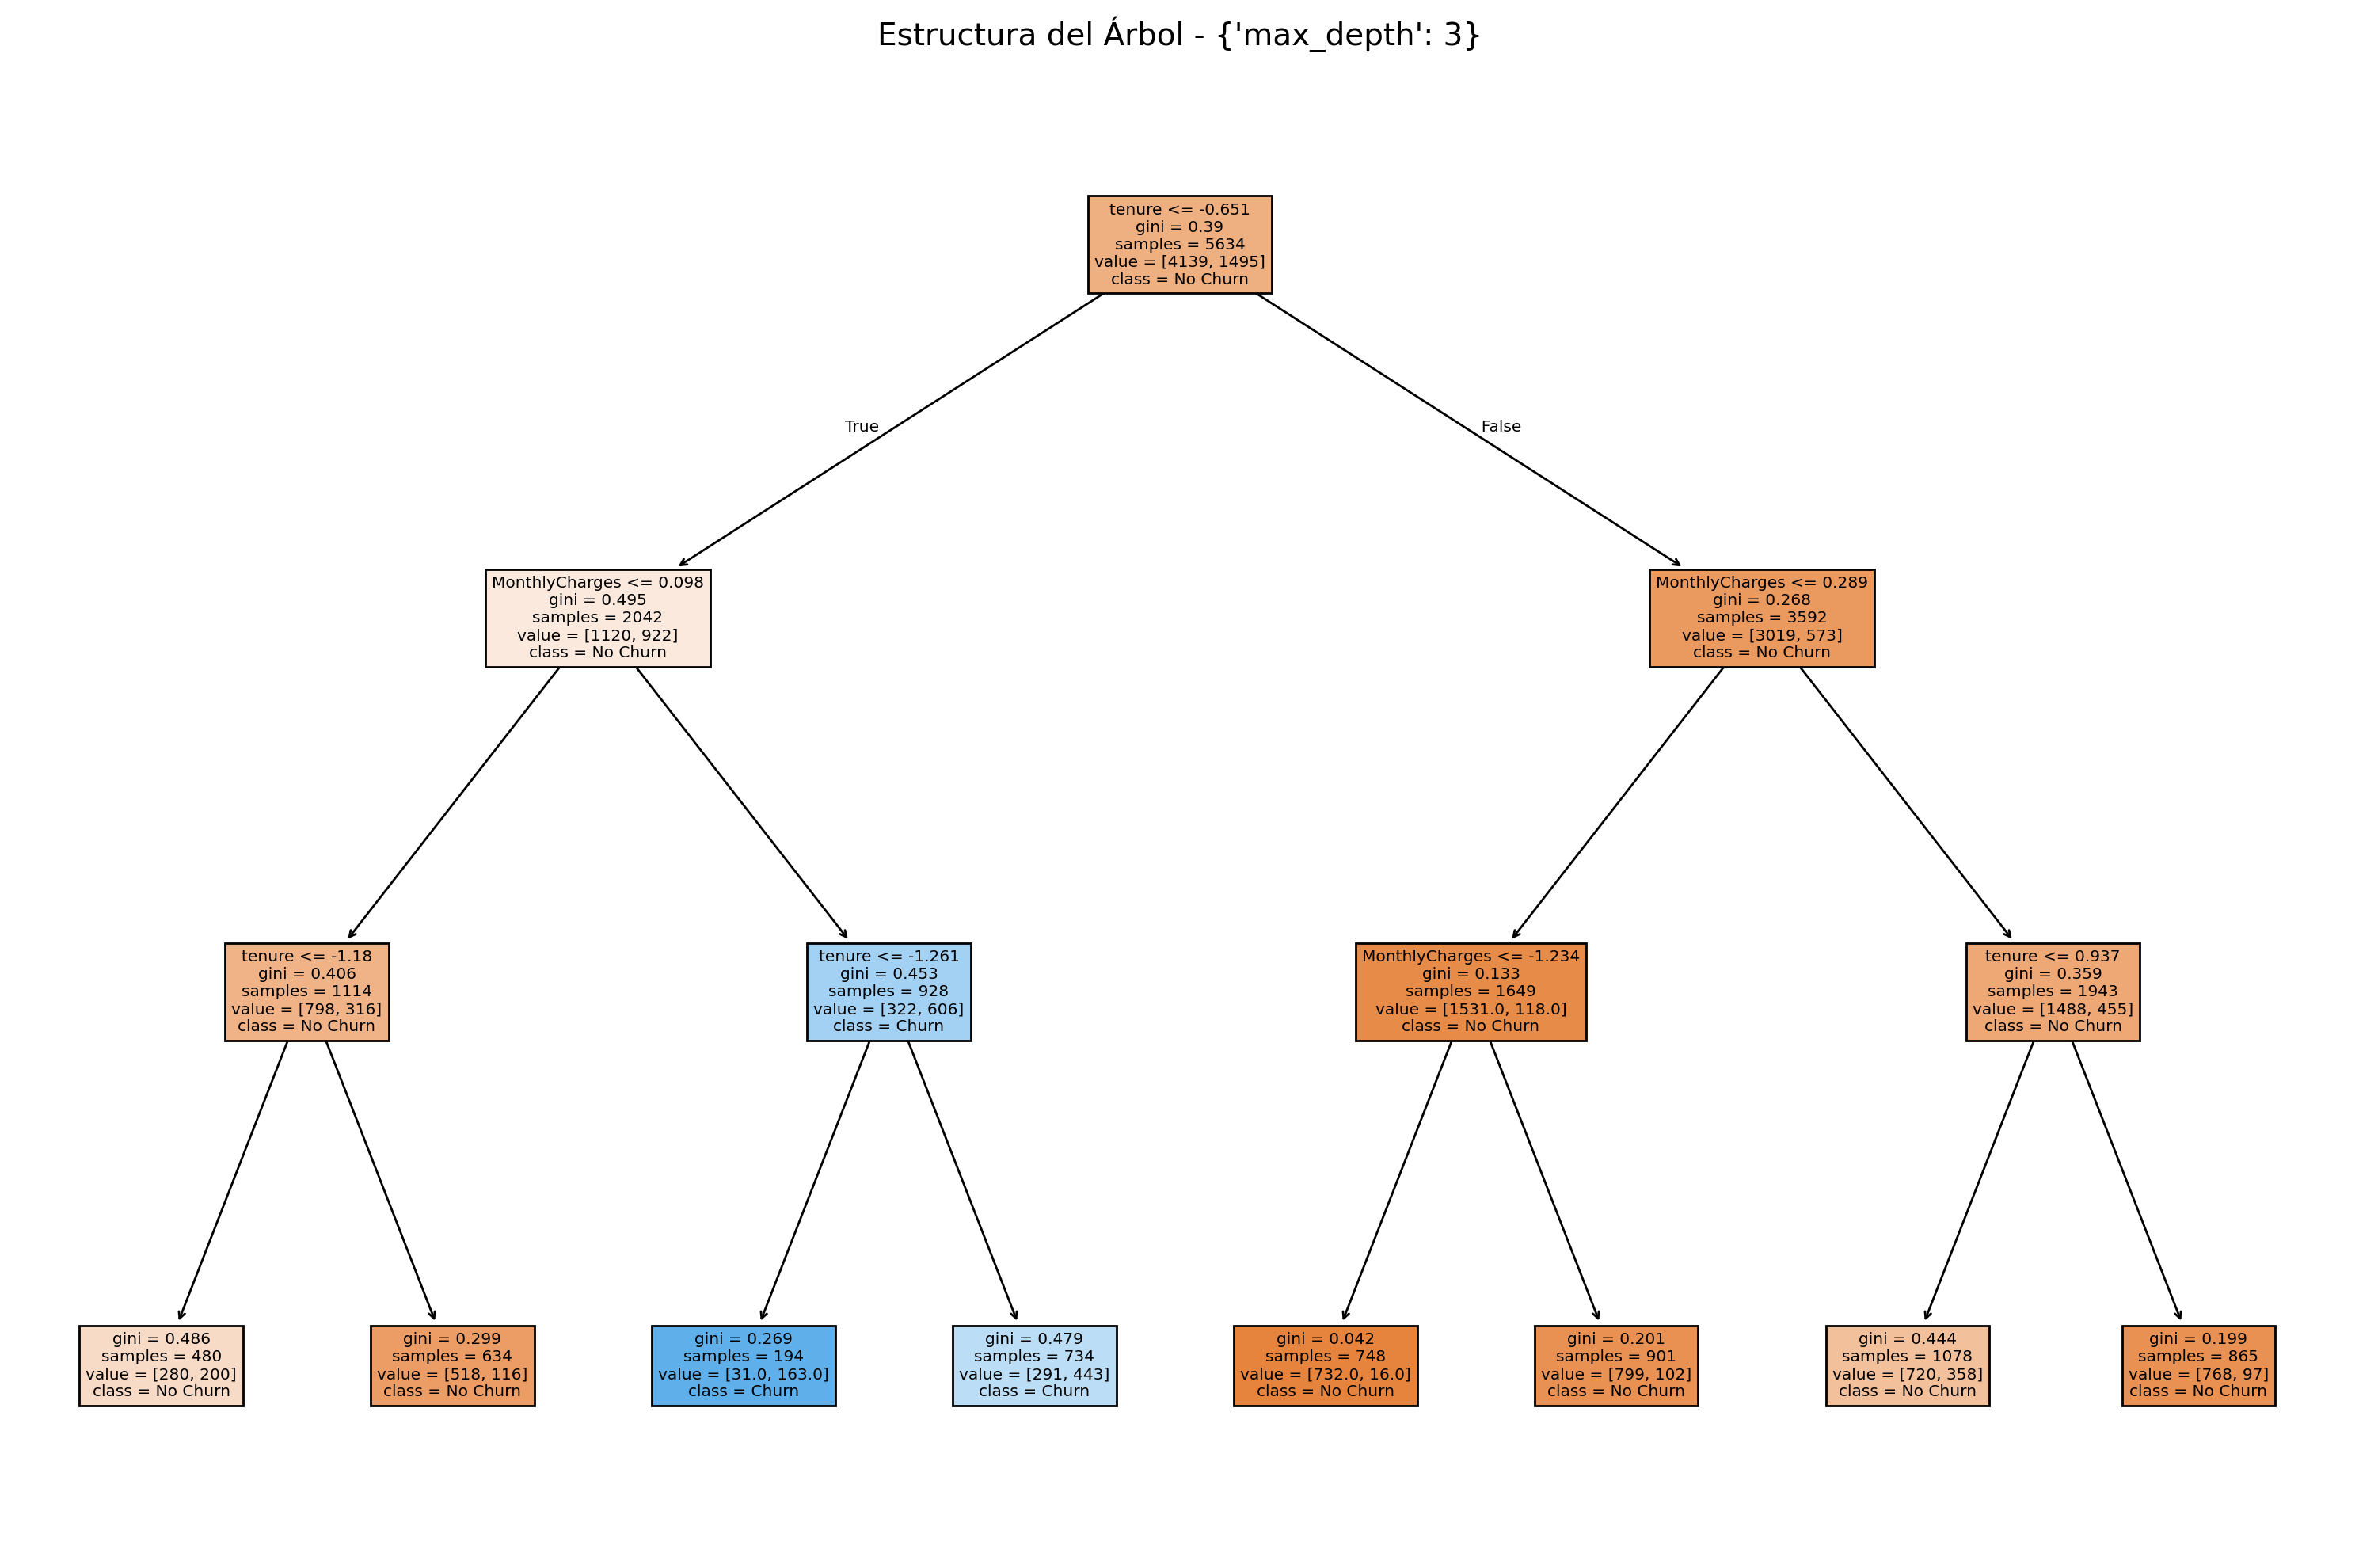

In [126]:
plot_class_boundaries(X_train_processed, y_train, 'MonthlyCharges', 'tenure', DecisionTreeClassifier, max_depth=3)

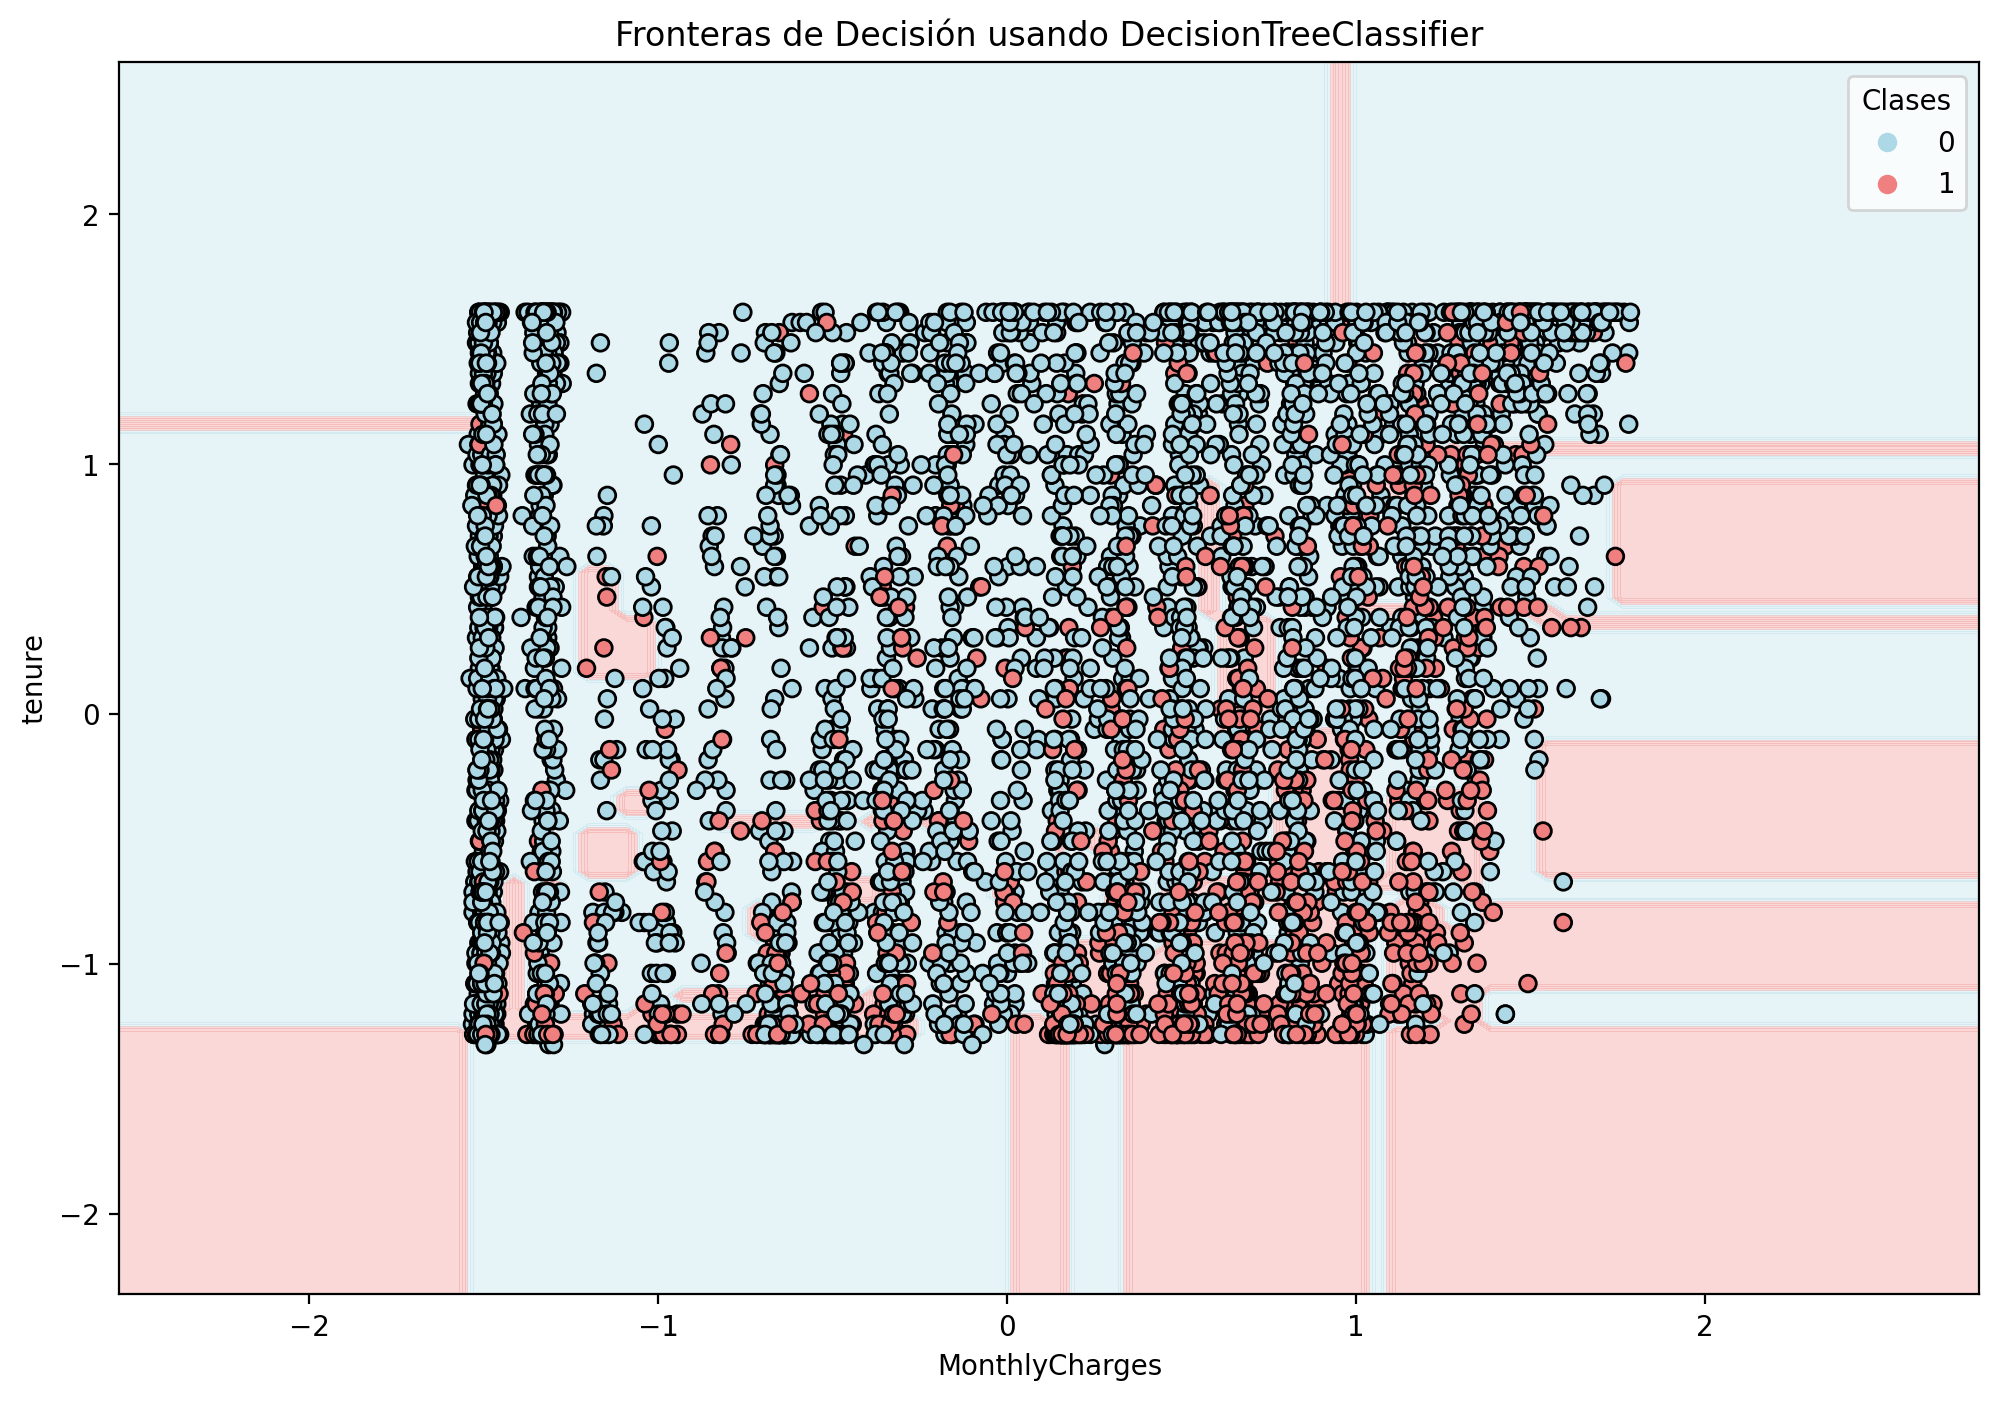

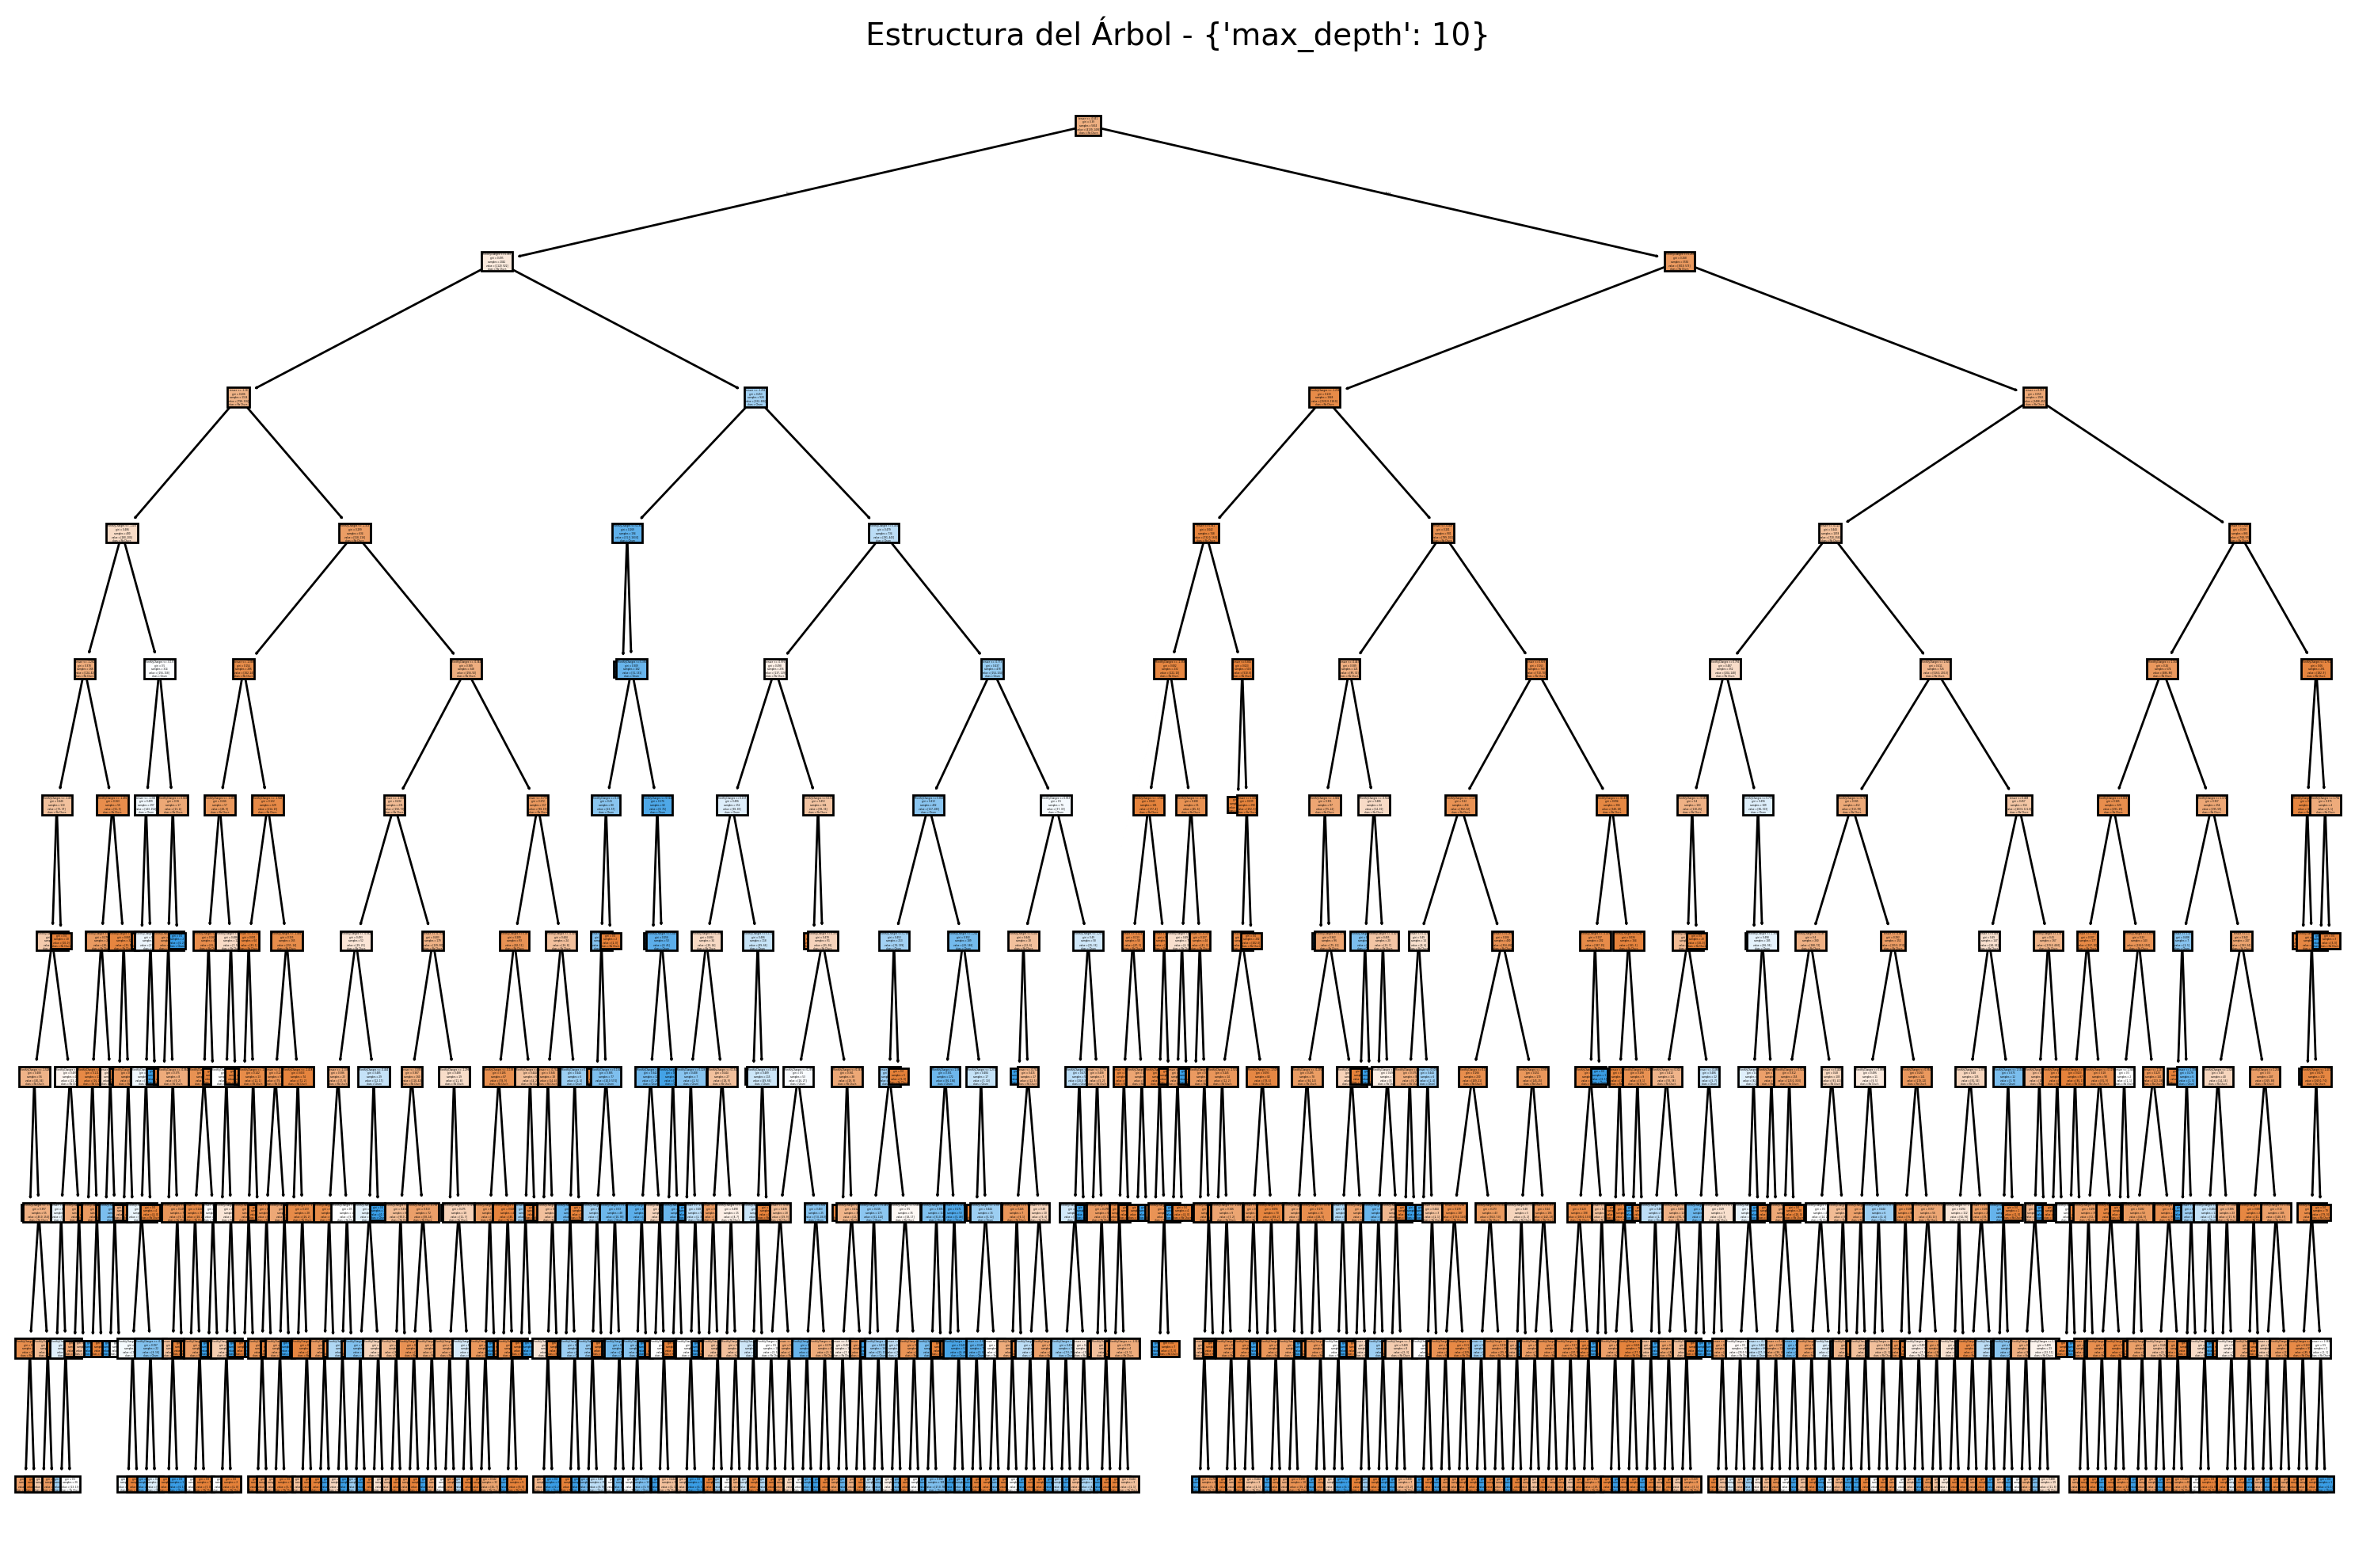

In [127]:
plot_class_boundaries(X_train_processed, y_train, 'MonthlyCharges', 'tenure', DecisionTreeClassifier, max_depth=10)

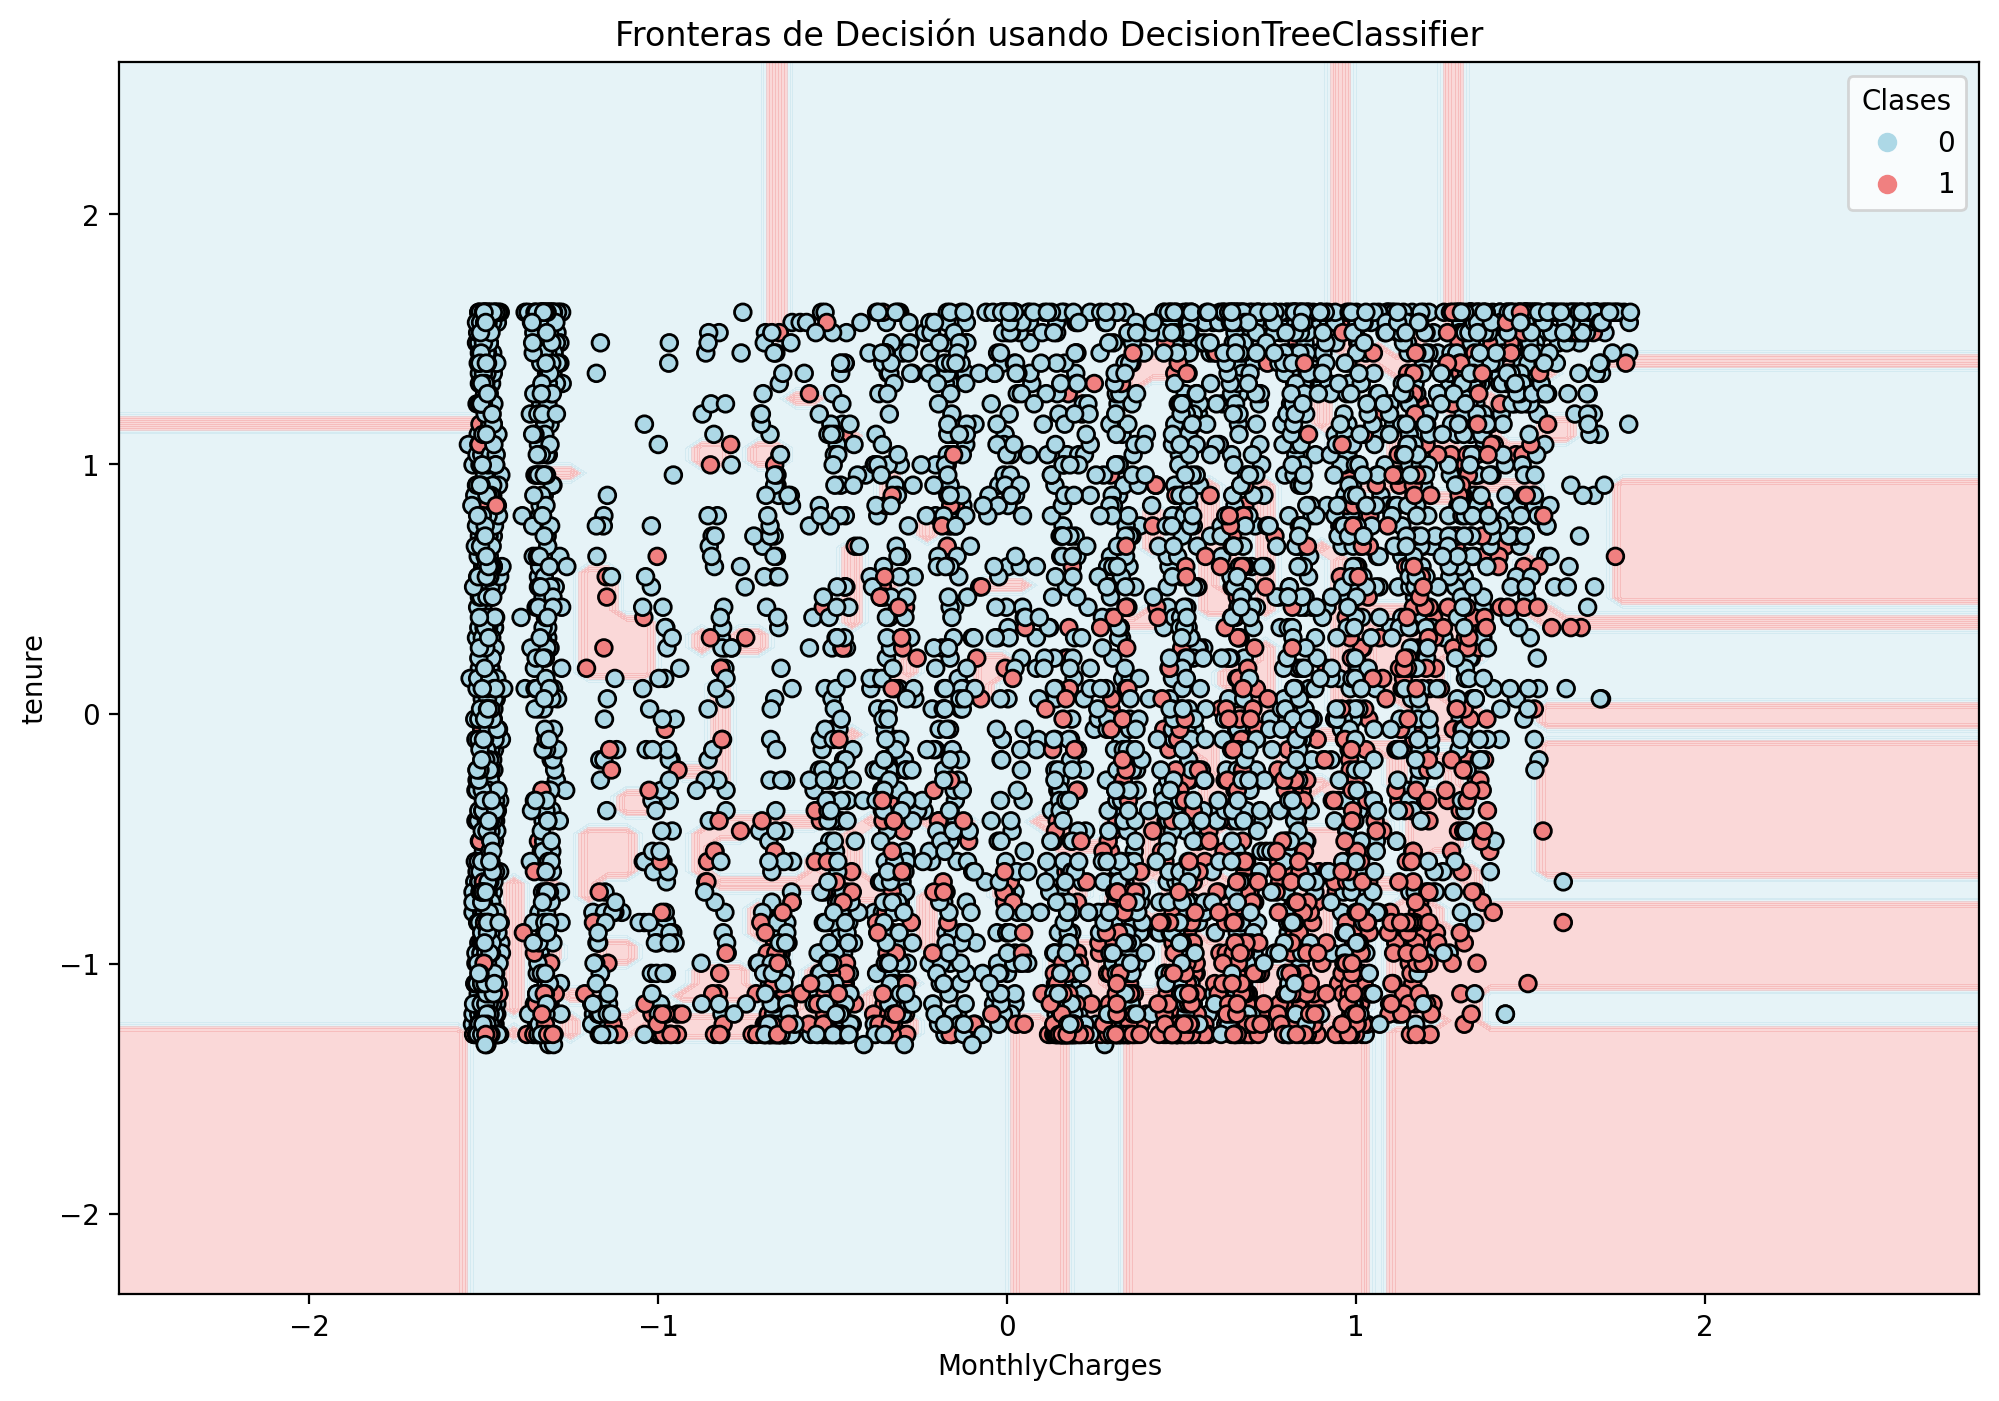

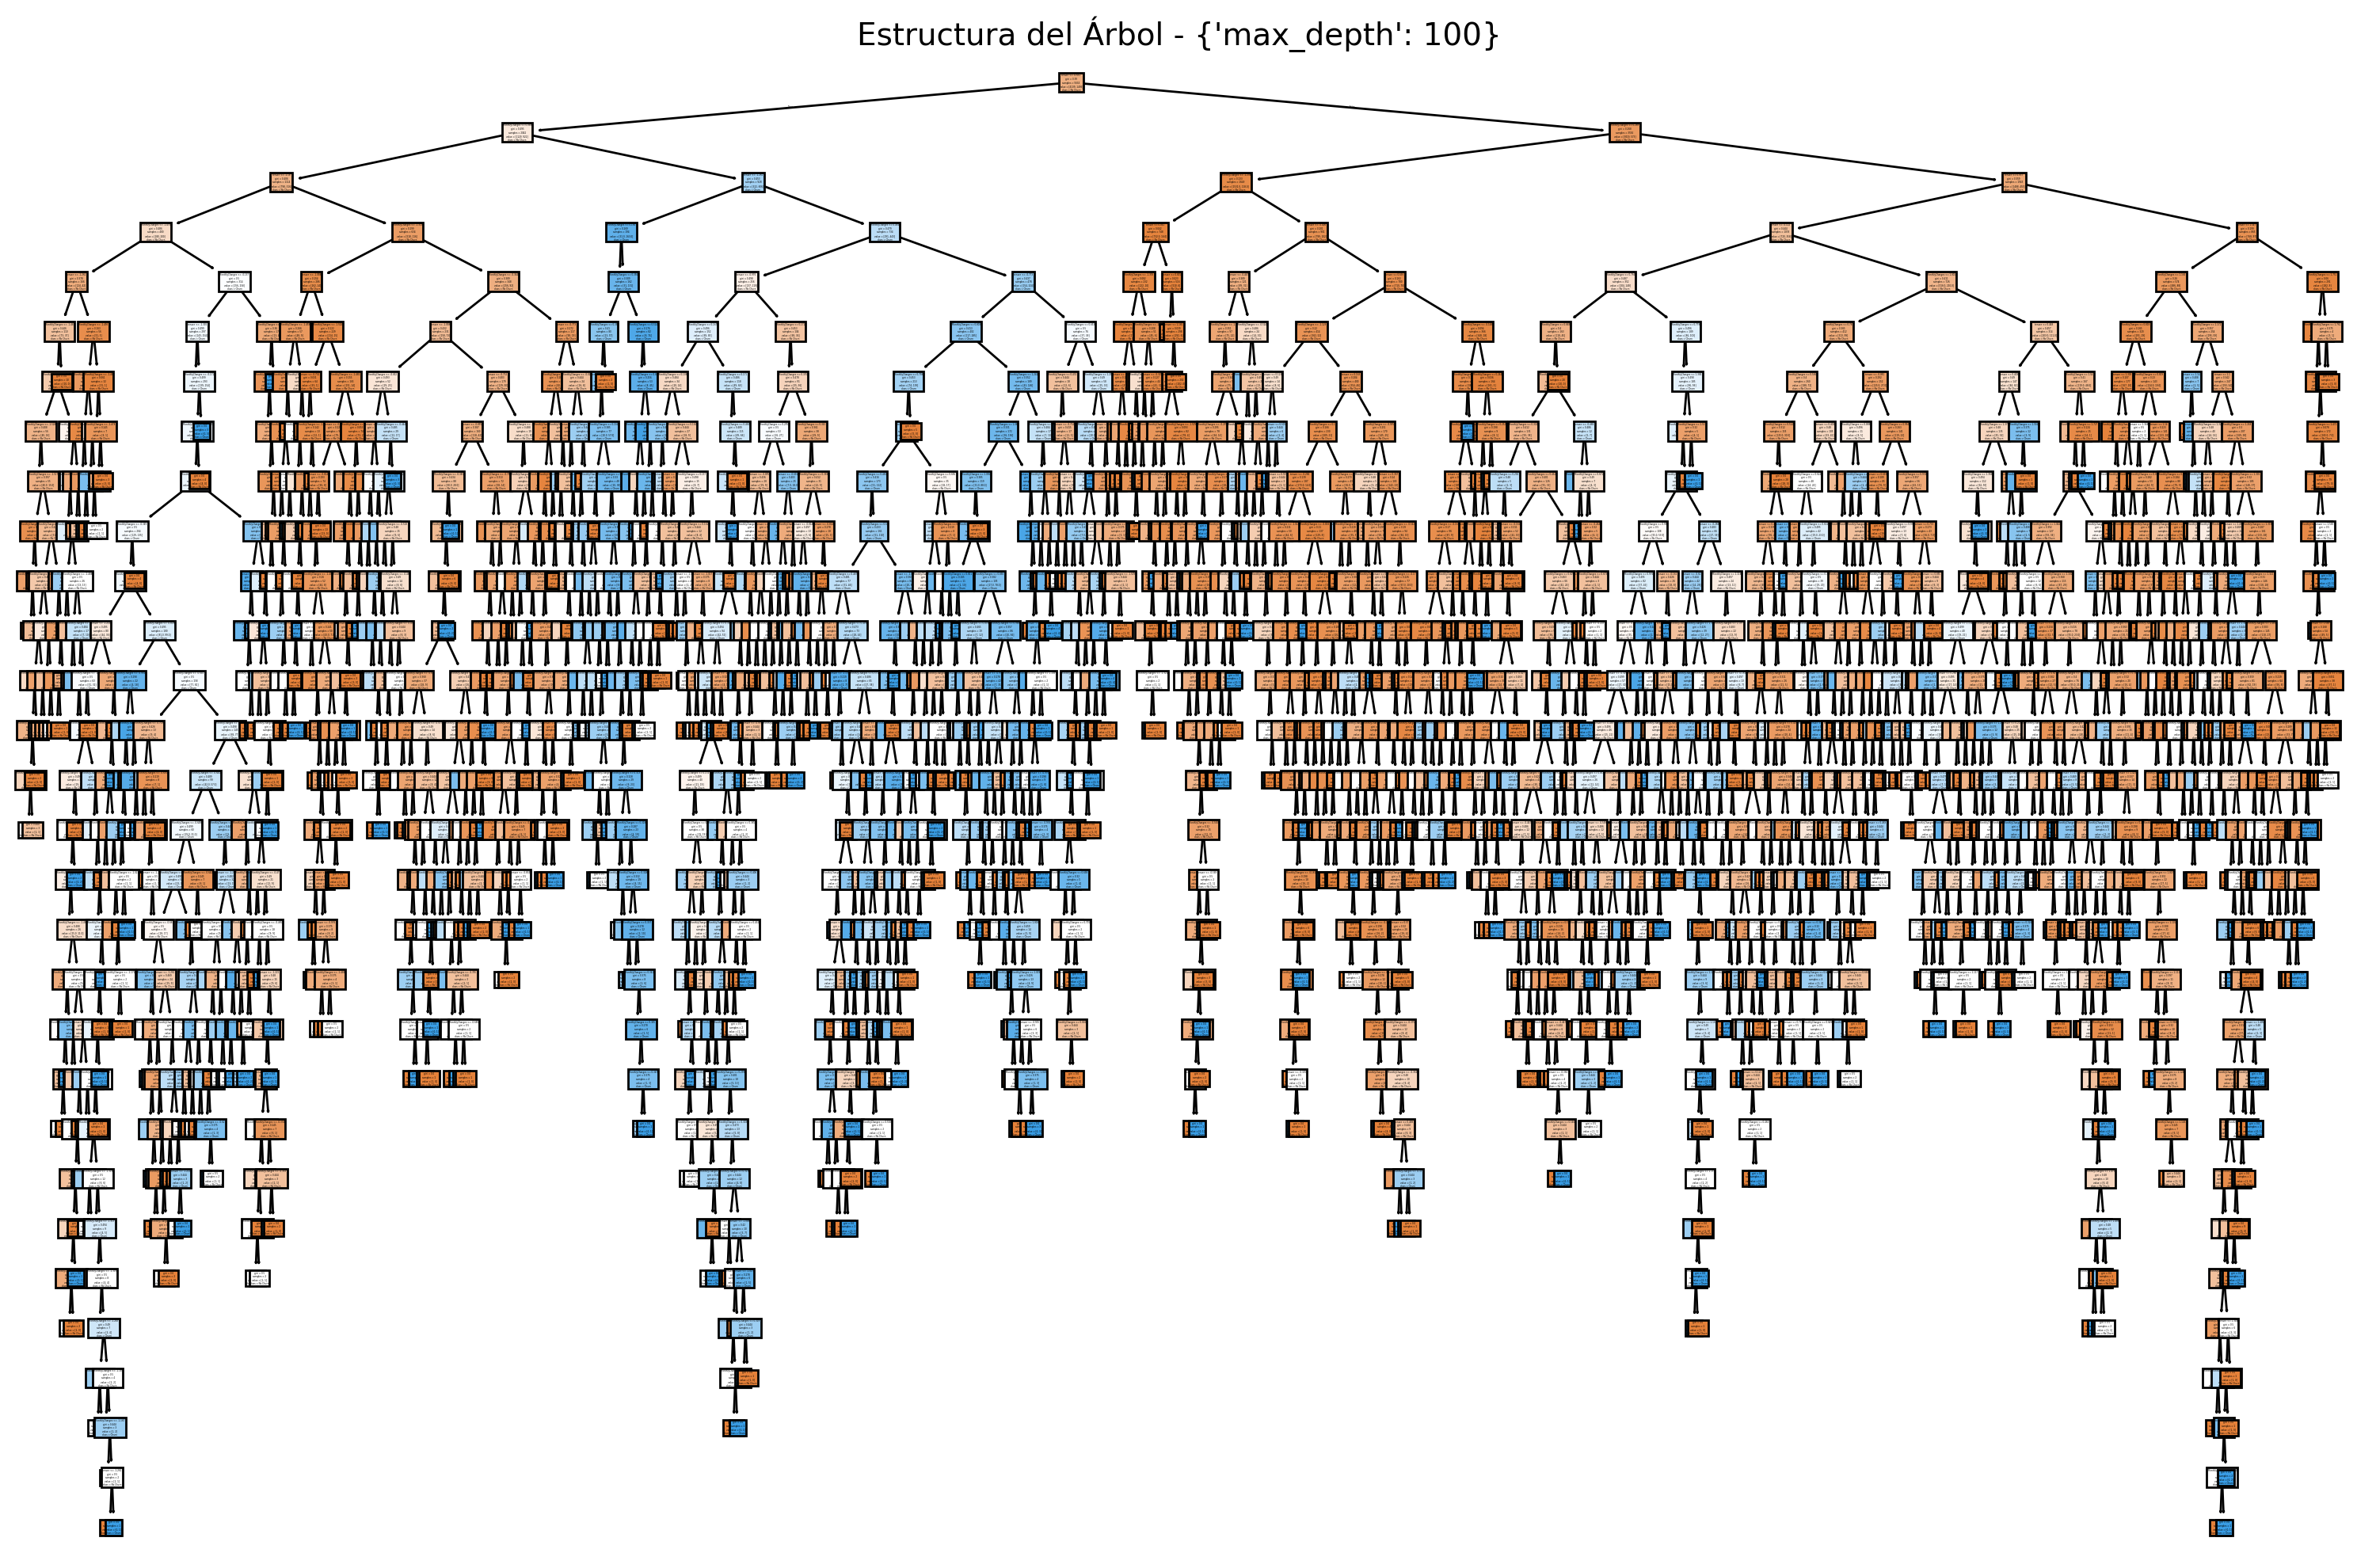

In [128]:
plot_class_boundaries(X_train_processed, y_train, 'MonthlyCharges', 'tenure', DecisionTreeClassifier, max_depth=100)

# PREGUNTAS POR HACER
1. por que hay diferencias entre las variables más importantes de shap y las del árbol de decision
2. la segunda pregunta de la sección 3 se hace para cada modelo o solo para el árbol de decisión?
3. la segunda variable más importante en el arbol de decision se guia segun la que tenga mayor valor de gini?
4. en el punto 4 preguntan por las dos variables numéricas más importantes discutidas en el punto anterior, pero las dos más importantes según el árbol son categoricas.  